## Preproccessing and Setup

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')
import pickle
# import dcor 
# from statsmodels.tsa.seasonal import seasonal_decompose

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
tf.random.set_seed(13)
np.random.seed(13)
# random.seed(13)
def mean_absolute_percentage_error(y_true, y_pred):
  for i in range(len(y_true)):
    if y_true[i] == 0:
      print('MAPE * Founded')
      y_true[i] = np.mean(y_true)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
data = pd.read_csv('DowDataset.csv', sep=',', date_parser=True)
dataset1 = data.iloc[:343].copy()
dataset2 = data.iloc[396:754].copy()
dataset_test = data.iloc[761:].copy()
full_dataset = pd.concat([dataset1, dataset2, dataset_test], axis=0 , ignore_index=True)
full_dataset = full_dataset.drop(['DATE', 'Flow_to_EQ'], axis=1)

In [ ]:
class approach1:
  def __init__(self, df, goal, window_size = 5):
    self.df = df.copy()
    self.goal = goal
    self.window_size = window_size

    self.df['trend'] = self.df[self.goal].rolling(self.window_size).mean().fillna(method='bfill')
    self.df['residual'] = self.df[self.goal] - self.df['trend']
    self.df['target'] = self.df['residual'].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_activation = 'tanh'
      self.model_layers = 2
      self.model_neurons = [6, 24]
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_activation = 'linear'
      self.model_layers = 2
      self.model_neurons = [10, 18]
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_activation = 'relu'
      self.model_layers = 2
      self.model_neurons = [14, 22]

    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std

    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(self.model_neurons[0], activation = self.model_activation, input_dim= self.X_train.shape[1]))
    self.model.add(BatchNormalization())
    if self.model_layers == 2:
      self.model.add(Dense(self.model_neurons[1], activation = self.model_activation))
    self.model.add(Dense(1))

    self.model.compile(optimizer= self.model_optimizer, loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1, shuffle = False)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('approach1.h5')

  def tune(self, max_epochs = 50):
    self.tune_results = {}
    OPTIMIZER = ['SGD', 'adam']
    ACTIVATION = ['relu', 'tanh']
    NUM_UNITS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
    NUM_LAYER = [1, 2]
    n = 1
    min_score = 100
    for activation in ACTIVATION: 
      for optimizer in OPTIMIZER:
        for num_layer in NUM_LAYER:
          if num_layer == 1:
            for neurons in NUM_UNITS:
              self.model = tf.keras.Sequential()
              self.model.add(Dense(neurons, activation=activation, input_dim= self.X_train.shape[1]))
              self.model.add(Dense(1))
              self.model.compile(optimizer= optimizer, loss='mse', metrics=['MAPE'])    
              history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
              # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - Score: ', min(history_Ann.history['val_loss']))
              self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Activation': activation, 'Layers':num_layer , 'Neurons': {neurons}, 'Score' : min(history_Ann.history['val_loss']), 'Epoch':history_Ann.history['val_loss'].index(min(history_Ann.history['val_loss']))}
              print(self.tune_results[f'{n}'])
              if min(history_Ann.history['val_loss']) < min_score:
                min_score = min(history_Ann.history['val_loss'])
                min_score_pos = n
              n+=1
          if num_layer == 2:
            for neurons in NUM_UNITS:
              for neurons2 in NUM_UNITS:
                self.model = tf.keras.Sequential()
                self.model.add(Dense(neurons, activation=activation, input_dim= self.X_train.shape[1]))
                self.model.add(Dense(neurons2, activation=activation))
                self.model.add(Dense(1))
                self.model.compile(optimizer= optimizer, loss='mse', metrics=['MAPE'])    
                history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)   
                # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - ', neurons2, ' - Score: ', min(history_Ann.history['val_loss'])) 
                self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Activation': activation, 'Layers':num_layer , 'Neurons': {neurons, neurons2}, 'Score' : min(history_Ann.history['val_loss']), 'Epoch':history_Ann.history['val_loss'].index(min(history_Ann.history['val_loss']))}
                print(self.tune_results[f'{n}'])
                if min(history_Ann.history['val_loss']) < min_score:
                  min_score = min(history_Ann.history['val_loss'])
                  min_score_pos = n
                n+=1  
    self.best_tuned = self.tune_results[f'{min_score_pos}']
  
  def testing(self, df_test):
    self.df_test = df_test.copy()
    self.df_test['trend'] = self.df_test[self.goal].rolling(self.window_size).mean().fillna(method='ffill')
    self.df_test = self.df_test.iloc[-self.df_test.shape[0]+self.window_size:]
    self.df_test['residual'] = self.df_test[self.goal] - self.df_test['trend']
    self.df_test['target'] = self.df_test['residual'].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.Xt = self.df_test[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON', 'residual']].fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill')
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.prediction = self.prediction*self.y_std + self.y_mean
    self.full_prediction = self.df_test['trend'].reset_index(drop=True) + self.prediction['Prediction']

    print('*** ANN estimation ***')
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()


In [ ]:
class approach2:
  def __init__(self, df, goal):
    self.df = df.copy()
    self.goal = goal

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_activation = 'tanh'
      self.model_layers = 2
      self.model_neurons = [4, 32]
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_activation = 'tanh'
      self.model_layers = 2
      self.model_neurons = [2, 18]
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_activation = 'linear'
      self.model_layers = 2
      self.model_neurons = [4, 10]

    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def series_to_supervised(self, n_in=5, n_out=1, dropnan=True):
    self.n_in = n_in
    self.n_out = n_out

    n_vars = 1 if type(self.X_train) is list else self.X_train.shape[1]
    df = pd.DataFrame(self.X_train)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('%s(t-%d)' % (df.columns[j],i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
      else:
        names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    self.supervised = agg
    self.supervised_train = self.supervised.values.reshape((self.supervised.shape[0], 1, self.supervised.shape[1]))
    self.Y_train = self.Y_train.iloc[n_in:]

  def training(self, max_epochs = 50):
    #print(neurons)
    self.model = tf.keras.Sequential()
    self.model.add(LSTM(self.model_neurons[0], activation = self.model_activation, return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
    self.model.add(Dropout(0.1))
    if self.model_layers == 2:
      self.model.add(BatchNormalization())
      self.model.add(LSTM(self.model_neurons[1], activation = self.model_activation))
    self.model.add(Dense(1))
    self.model.compile(loss='mse', optimizer=self.model_optimizer, metrics=['mape'])  
    history = self.model.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('approach2.h5')
  
  def tune(self, max_epochs = 50):
    self.tune_results = {}
    OPTIMIZER = ['SGD', 'adam']
    ACTIVATION = ['relu', 'linear', 'tanh']
    NUM_UNITS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
    NUM_LAYER = [1, 2]
    n = 1
    min_score = 100
    for activation in ACTIVATION:
      for optimizer in OPTIMIZER:
        for num_layer in NUM_LAYER:
          if num_layer == 1:
            for neurons in NUM_UNITS:
              self.models = tf.keras.Sequential()
              self.models.add(LSTM(neurons, activation = activation, return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
              self.models.add(Dropout(0.1))
              self.models.add(Dense(1))
              self.models.compile(loss='mse', optimizer=optimizer, metrics=['mape'])  
              history = self.models.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
              # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - Score: ', min(history.history['val_loss']))
              self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Activation': activation, 'Layers':num_layer , 'Neurons': {neurons}, 'Score' : min(history.history['val_loss']), 'Epoch':history.history['val_loss'].index(min(history.history['val_loss']))}
              print(self.tune_results[f'{n}'])
              if min(history.history['val_loss']) < min_score:
                min_score = min(history.history['val_loss'])
                min_score_pos = n
              n+=1
          if num_layer == 2:
            for neurons in NUM_UNITS:
              for neurons2 in NUM_UNITS:
                self.models = tf.keras.Sequential()
                self.models.add(LSTM(neurons, activation = activation, return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
                self.models.add(Dropout(0.1))
                self.models.add(BatchNormalization())
                self.models.add(LSTM(neurons2, activation = activation, return_sequences=True))
                self.models.add(Dense(1))
                self.models.compile(loss='mse', optimizer=optimizer, metrics=['mape'])  
                history = self.models.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1) 
                # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - ', neurons2, ' - Score: ', min(history.history['val_loss'])) 
                self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Activation': activation, 'Layers':num_layer , 'Neurons': {neurons, neurons2}, 'Score' : min(history.history['val_loss']), 'Epoch':history.history['val_loss'].index(min(history.history['val_loss']))}
                print(self.tune_results[f'{n}'])
                if min(history.history['val_loss']) < min_score:
                  min_score = min(history.history['val_loss'])
                  min_score_pos = n
                n+=1  
    self.best_tuned = self.tune_results[f'{min_score_pos}'] 

  def testing(self, df_test):
    self.df_test = df_test.copy()
    
    def series_to_supervised_test(X_test, n_in=self.n_in, n_out=self.n_out, dropnan=True):
      n_vars = 1 if type(X_test) is list else X_test.shape[1]
      df = pd.DataFrame(X_test)
      cols, names = list(), list()
      # input sequence (t-n, ... t-1)
      for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j],i)) for j in range(n_vars)]
      # forecast sequence (t, t+1, ... t+n)
      for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
          names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
          names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
      # put it all together
      agg = pd.concat(cols, axis=1)
      agg.columns = names
      # drop rows with NaN values
      if dropnan:
        agg.dropna(inplace=True)
      supervised = agg
      supervised_test = supervised.values.reshape((supervised.shape[0], 1, supervised.shape[1]))
      return supervised_test
    # self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.Xt = self.df_test[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')

    # self.Xt = self.df_test[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='ffill')
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill').iloc[self.n_in:]
    self.supervised_test = series_to_supervised_test(self.X_test)
    
    self.prediction = pd.DataFrame(self.model.predict(self.supervised_test).reshape(-1,1), columns=['Prediction'])
    self.full_prediction = self.prediction*self.y_std + self.y_mean
    
    print('*** LSTM estimation ***')
    # print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    # print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [ ]:
class approach3:
  def __init__(self, df, goal):    
    self.df = df.copy()
    self.goal = goal

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='bfill')
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill')
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill')
    
    # self.X = self.df[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='bfill')
    self.Y = self.df['target'].fillna(method='bfill')
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = self.X
    self.Y_train = self.Y
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
    # self.model.save('approach3.h5')
    pickle.dump(self.model, open('approach3.sav', 'wb'))
  
  def testing(self, df_test):
    self.df_test = df_test.copy()
    
    if self.goal == 'D_COD_ON':
      self.X_test = self.df_test[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='bfill').fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.X_test = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill').fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.X_test = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill').fillna(method='ffill')

    # self.X_test = self.df_test[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='ffill').fillna(method='bfill')
    self.X_test = (self.X_test - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill')
        
    self.prediction = self.model.predict(self.X_test)
    # self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])
    self.amplifier = 10
    full_prediction = self.prediction*self.y_std + self.y_mean

    self.full_prediction = full_prediction
    # self.full_prediction = np.zeros(len(self.prediction))
    # self.full_prediction[0] = self.df_test[self.goal].reset_index(drop=True)[0] + full_prediction[0] 
    # for i in range(1,len(self.prediction)):
    #   self.full_prediction[i] = self.full_prediction[i-1] - full_prediction[i]
    # self.full_prediction = 3*self.prediction
    
    print('*** Delta estimation ***')
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

# BT_C_MVLSS

In [ ]:
active_target = "BT_C_MVLSS"
dataset = dataset1.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        343 non-null    object 
 1   Flow_to_EQ  343 non-null    object 
 2   Flow_efl    343 non-null    float64
 3   BT_C_MLSS   343 non-null    float64
 4   BT_C_MVLSS  343 non-null    float64
 5   BT_N_MLSS   343 non-null    float64
 6   BT_N_MVLSS  343 non-null    float64
 7   D_SS        343 non-null    float64
 8   EQ_N        343 non-null    float64
 9   BT_C_N      343 non-null    float64
 10  BT_N_N      343 non-null    float64
 11  D_N         343 non-null    float64
 12  OxT_PH_PM   343 non-null    float64
 13  EQ_PH       343 non-null    float64
 14  BT_N_PH     343 non-null    float64
 15  D_PH        343 non-null    float64
 16  BT_N_DO     343 non-null    float64
 17  BT_C_DO     343 non-null    float64
 18  Clari_DO    343 non-null    float64
 19  F/M         343 non-null    f

In [ ]:
# cut_off = 68
# active_targets = ['BT_C_MVLSS', 'EQ_COD', 'D_COD_ON']
# for j in range(0,3):
#   active_target = active_targets[j]
#   print('\n********************************************************************************************\n')
#   print(f'\n************************ {active_target} *****************************\n')
#   print('\n********************************************************************************************\n')
#   for i in range(2,8):
#     print('\n********************************************************************************************')
#     print(f'Trial with {i} day rolling windowning')
#     app1 = approach1(dataset.iloc[:-cut_off], active_target, i)
#     app1.training()
#     app1.testing(dataset.iloc[5:-cut_off])
#     app1.full_prediction.shape

## Approach 1

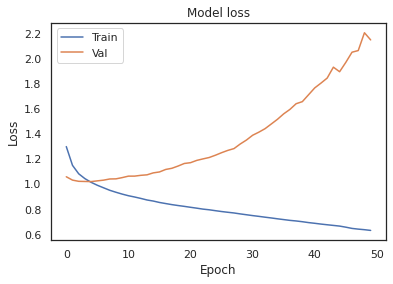

*** ANN estimation ***
MAPE:  5.714480571671706
R2:  0.5233592058116361
RMSE:  588.2049366549096


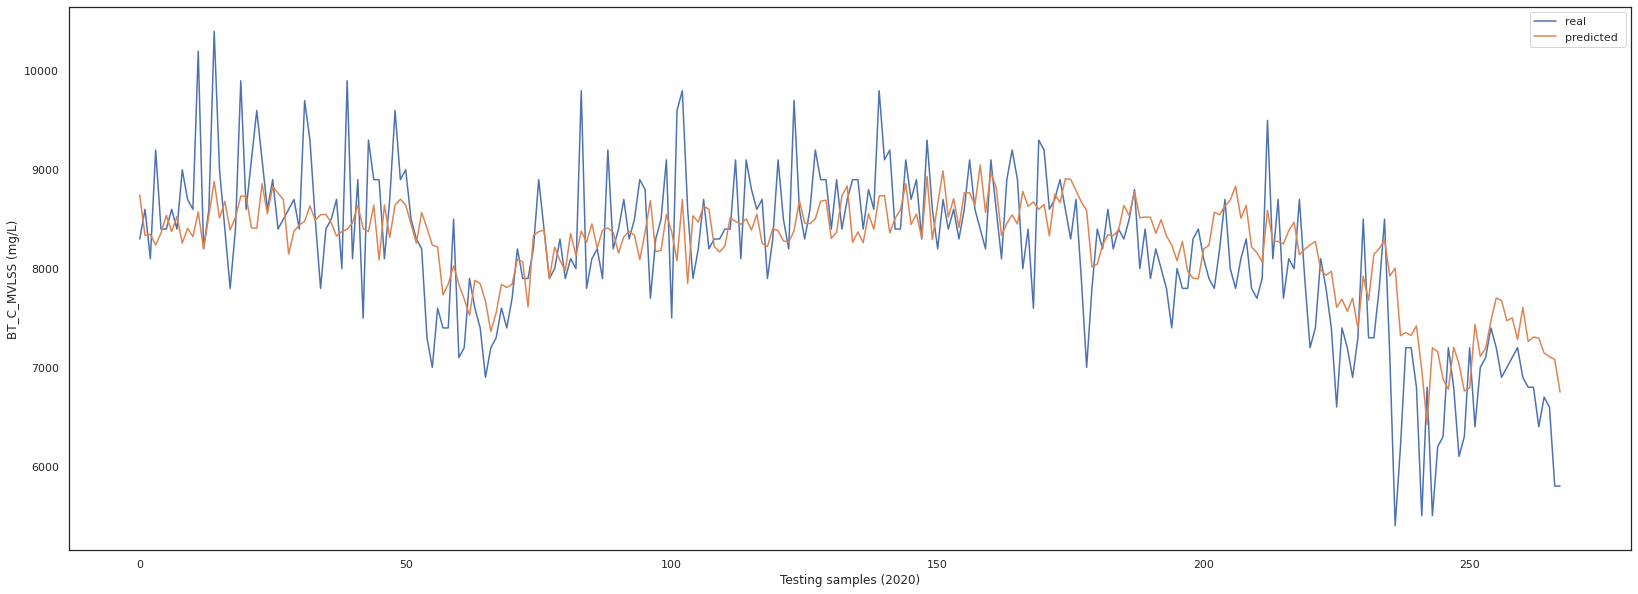

(268,)

In [ ]:
cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target, 5)
app1.training()
app1.testing(dataset.iloc[2:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

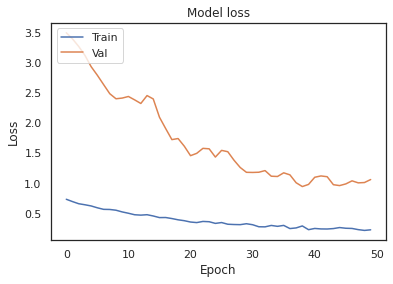

*** LSTM estimation ***
MAPE:  10.372461833707087
R2:  0.727082338053518
RMSE:  445.0910704210085


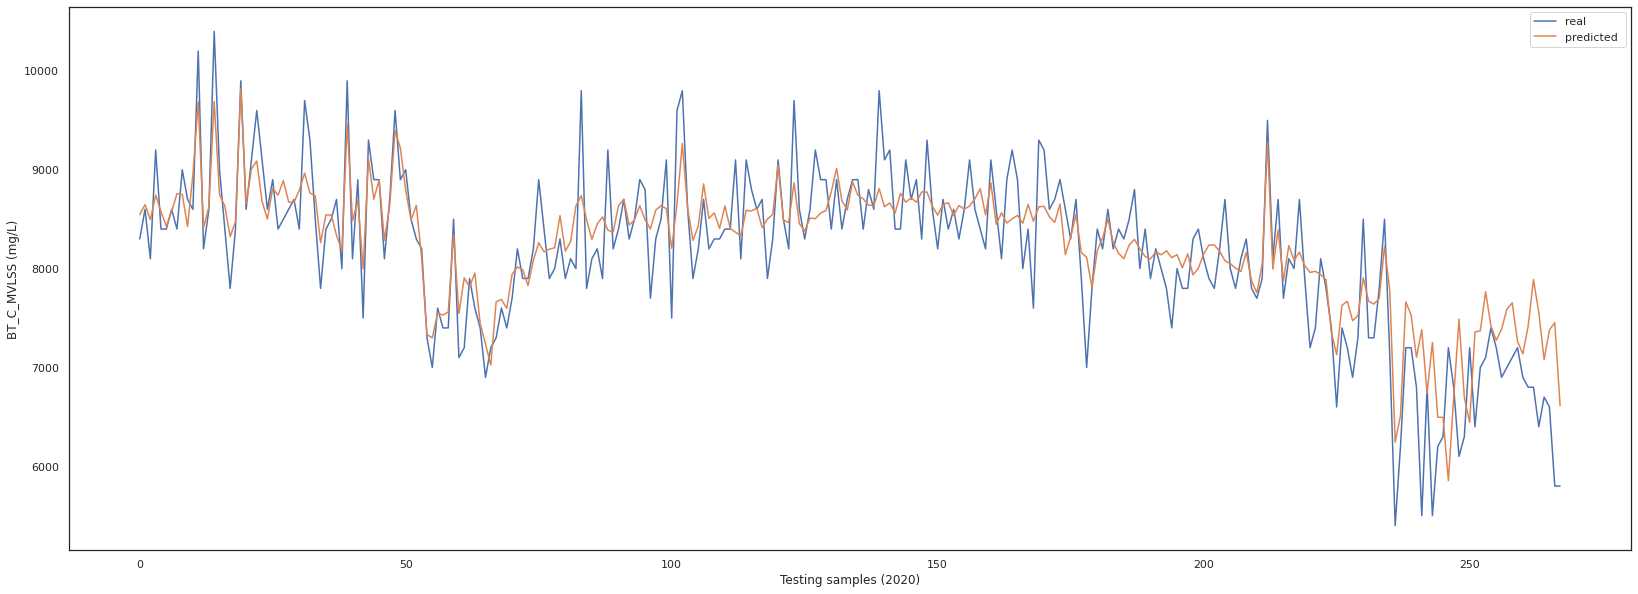

(268, 1)

In [ ]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=7)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  5.810163536553229
R2:  0.47958318486012486
RMSE:  614.6228762349515


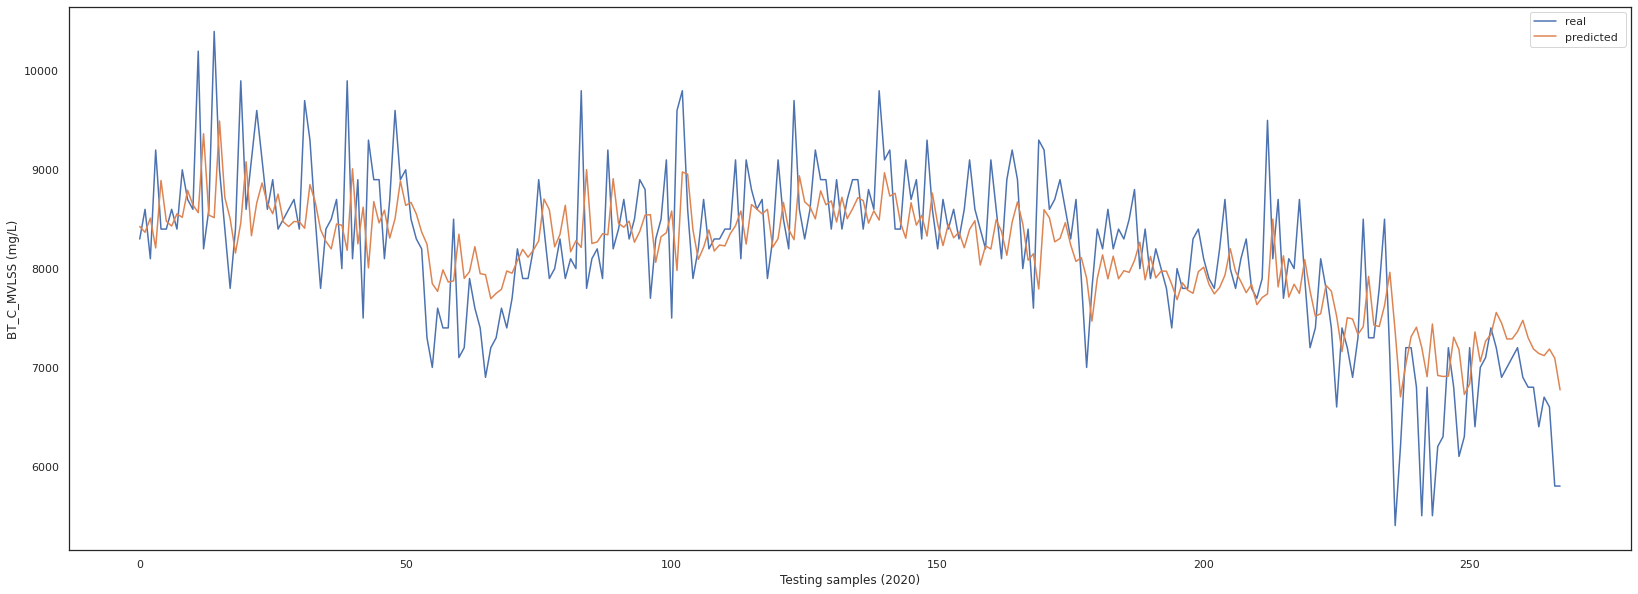

(268,)

In [ ]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

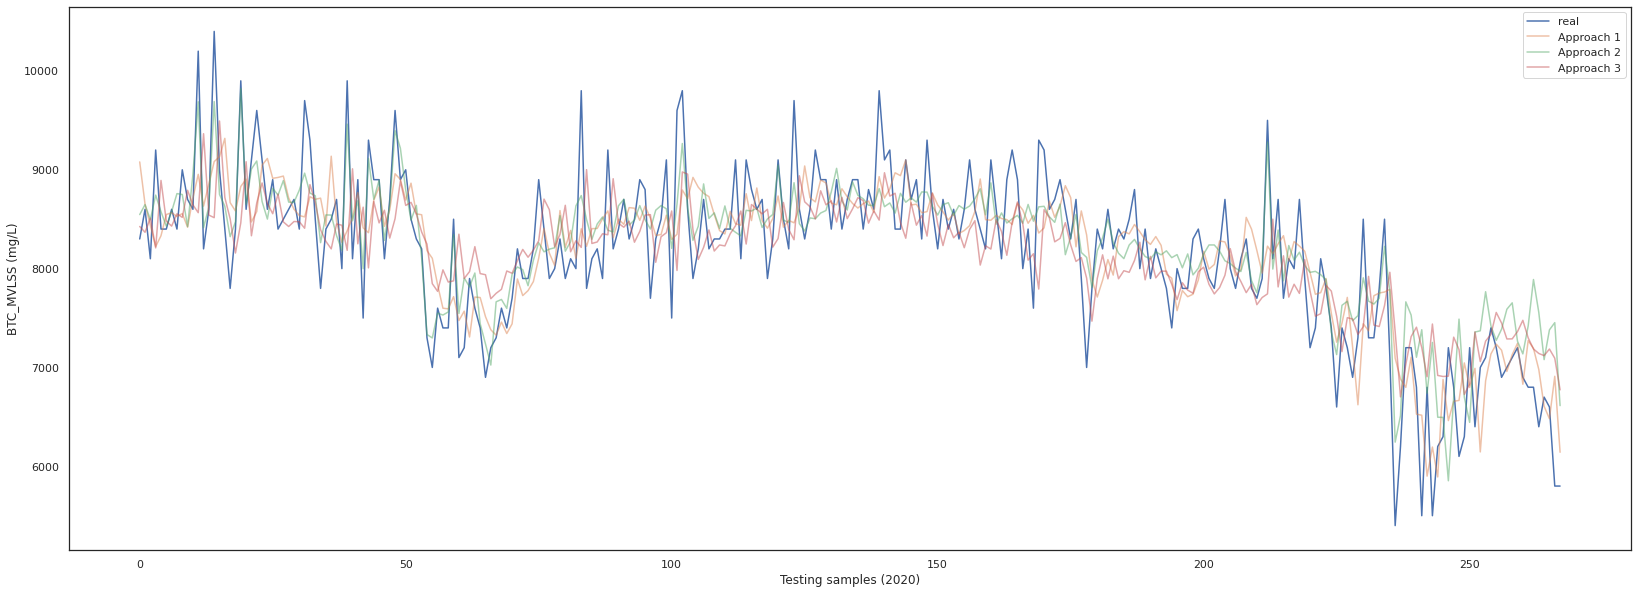

In [ ]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [ ]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      26052.749340
1      25667.539618
2      25441.859965
3      25175.780721
4      25800.712446
           ...     
263    21676.816979
264    20806.027721
265    21048.444563
266    21457.277400
267    19529.140441
Length: 268, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  5.045138374241079
R2:  0.6038134293228127
RMSE:  536.2693001215457


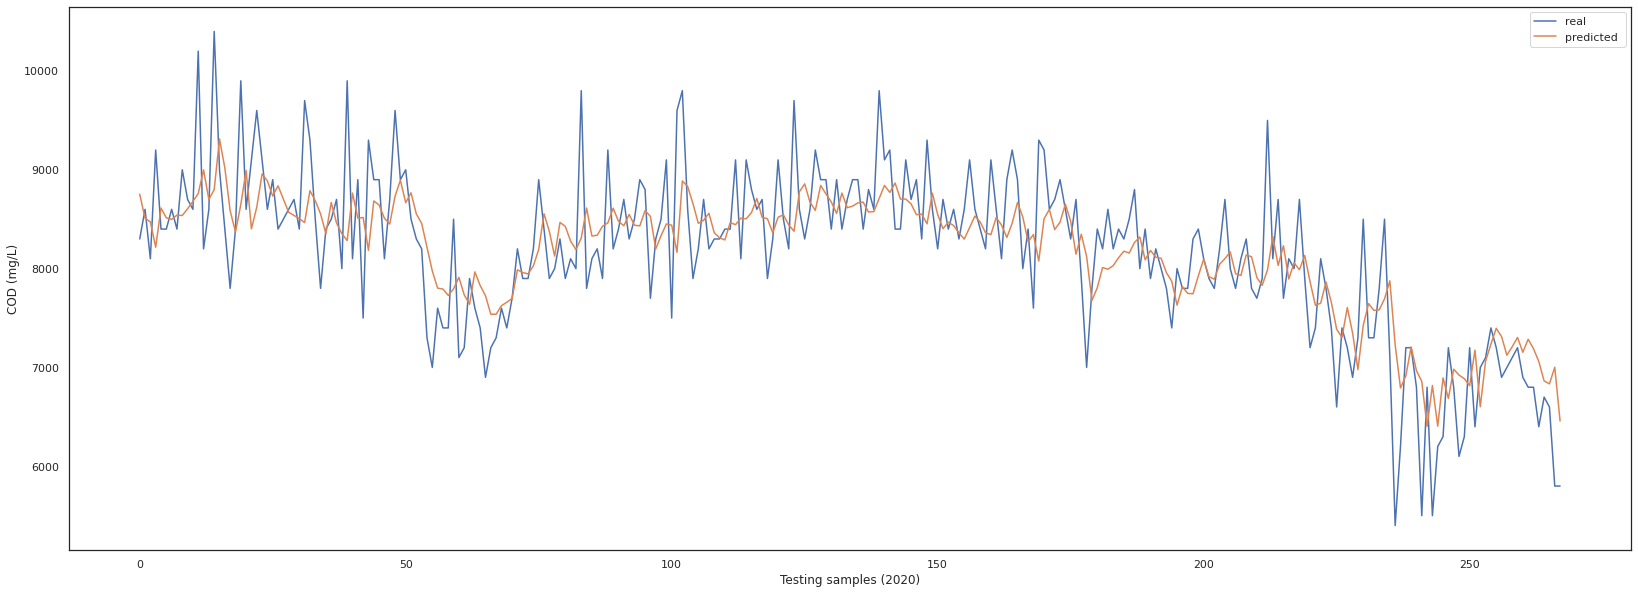

In [ ]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  4.625302744307988
R2:  0.6788265388533464
RMSE:  482.8396054073126


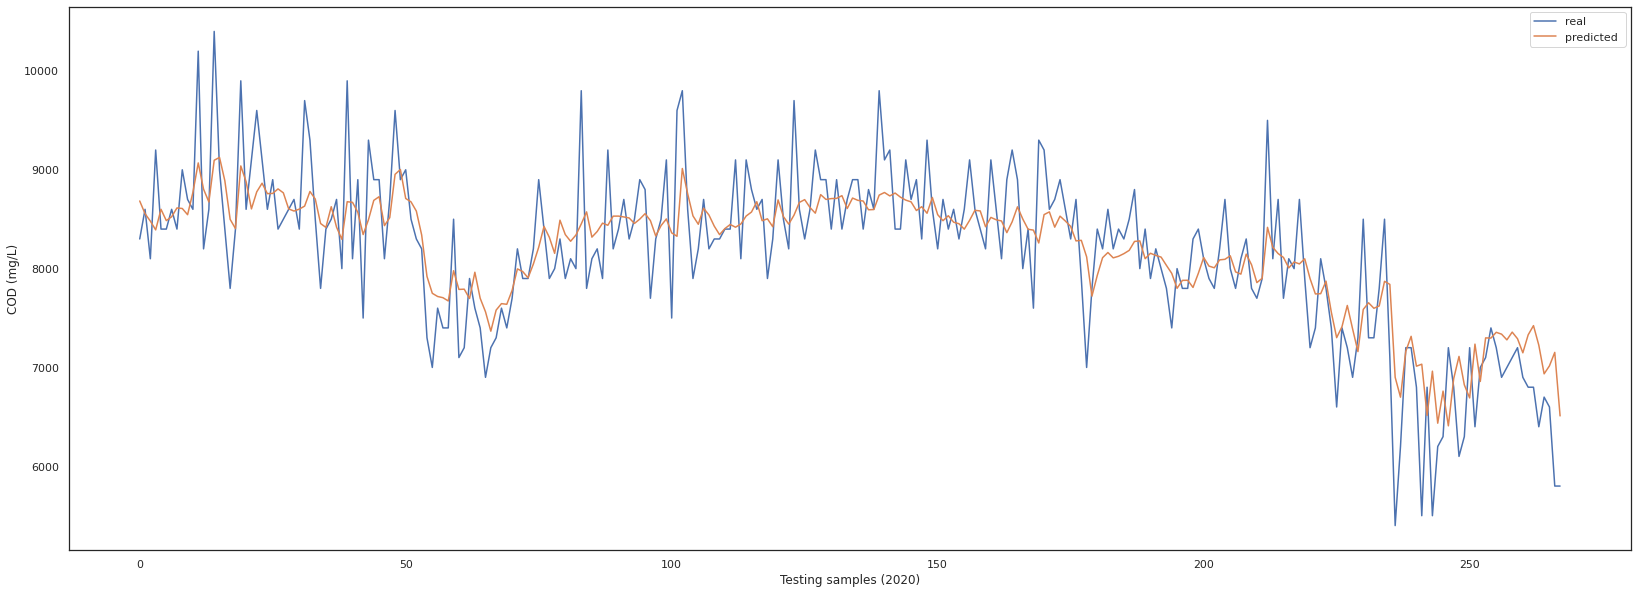

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

In [ ]:
class Ensemble:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[['model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[['model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 1s 26ms/step - loss: 0.4078 - MAPE: 129.1695 - val_loss: 5.2650 - val_MAPE: 121.1349
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.3810 - MAPE: 121.0867 - val_loss: 4.7908 - val_MAPE: 114.2726
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 0.3541 - MAPE: 115.5569 - val_loss: 4.3707 - val_MAPE: 107.8511
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.3334 - MAPE: 112.7793 - val_loss: 3.9805 - val_MAPE: 101.5387
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.3149 - MAPE: 111.6814 - val_loss: 3.6108 - val_MAPE: 95.1720
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.2972 - MAPE: 110.8501 - val_loss: 3.2896 - val_MAPE: 89.8714
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2828 - MAPE: 110.7911 - val_loss: 2.9957 - val_MAPE: 85.0652
Epoch 8/50
8/8 [==============================] - 0s 7ms/step - 

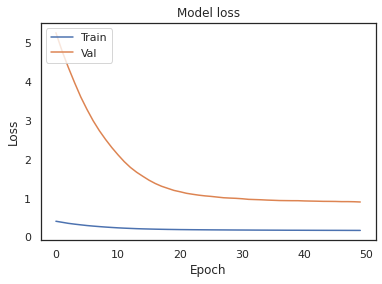

In [ ]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 8.960943   9.933569   9.240317  11.38008    9.804658   8.8008795
  9.55753   11.481323  11.259186   8.540816  13.456789  23.735733
  8.410662   9.734293  23.13532   11.43181    9.46958    8.411481
  8.776915  26.303303  10.514426  14.665815  15.965159  10.318465
  8.880182  11.333983  10.922792  11.965708  10.126036  10.306762
 11.75489   13.983506  11.511617  11.046809   8.401975   9.347474
  8.759993   8.421872   8.767884  20.235373   8.689698   9.98303
 10.828275  14.74451   10.740684  12.16968    8.438858   9.909774
 18.918692  16.996521  11.570915   9.003225  10.188762   9.156429
 16.299122  13.909774  11.840271  13.375096  12.700923   8.412533
 14.907432  10.101242  11.245608  10.429356  13.695635  16.347733
 18.08873   11.760518  11.543974  13.146305  10.100964   9.503417
 10.110724  11.048969   9.337272   8.39752    9.116242   8.868498
  8.547534   9.217349   9.038113   8.403319  10.644713  11.247958
  8.770754   8.4144335  

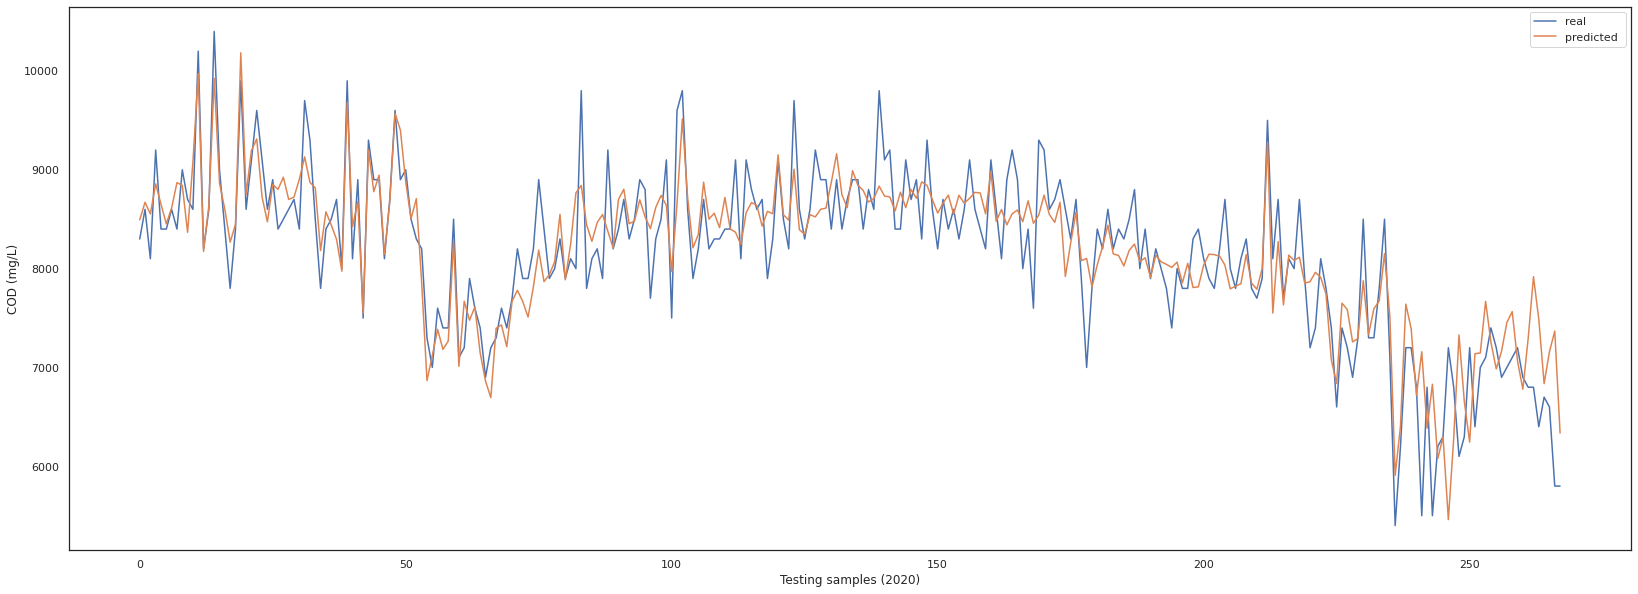

In [ ]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


In [ ]:
class Ensemble2:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[[self.goal, 'model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 1s 26ms/step - loss: 0.9890 - MAPE: 165.5790 - val_loss: 13.5150 - val_MAPE: 204.5811
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.9375 - MAPE: 163.9465 - val_loss: 12.6425 - val_MAPE: 197.2838
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8846 - MAPE: 162.5995 - val_loss: 11.8813 - val_MAPE: 190.6685
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8413 - MAPE: 160.0631 - val_loss: 11.1807 - val_MAPE: 184.4076
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8021 - MAPE: 158.1067 - val_loss: 10.5233 - val_MAPE: 178.3658
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.7644 - MAPE: 155.4955 - val_loss: 9.9432 - val_MAPE: 172.8728
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.7325 - MAPE: 151.6304 - val_loss: 9.4112 - val_MAPE: 167.6927
Epoch 8/50
8/8 [==============================] - 0s 5ms

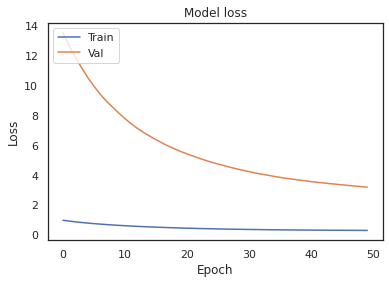

In [ ]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 8.834994   9.867808   8.818236  11.117853  10.400593   8.5278425
  9.31061   11.146428  11.099075   8.690012  13.555498  25.942347
  8.954622   9.679354  25.6773    11.154645   9.191699   8.389753
  8.491021  29.120886   9.826683  14.598173  16.525545   9.559628
  8.542297  11.438388  10.578848  12.498931  10.0069475 10.040324
 11.449853  13.977488  11.301921  10.594196   8.431585   9.050702
  8.779641   8.394117   8.657683  22.809544   9.187436   9.991811
  9.357426  15.442247  10.206588  12.358752   8.442349   9.911794
 20.3051    18.02678   11.318109   8.577764   9.867493   8.625183
  9.1091175  8.848267   8.8161545  8.808652   8.835814   8.397843
  8.843306   8.6738205  8.557979   8.689704   8.848267   8.758281
  8.749531   8.758475   8.828401   8.698916   8.632022   8.835164
  8.719341   8.848267   8.683271   8.418133   8.710798   8.438042
  8.530926   9.000358   8.46752    8.467689  10.191301  10.915601
 10.026637   8.428009  

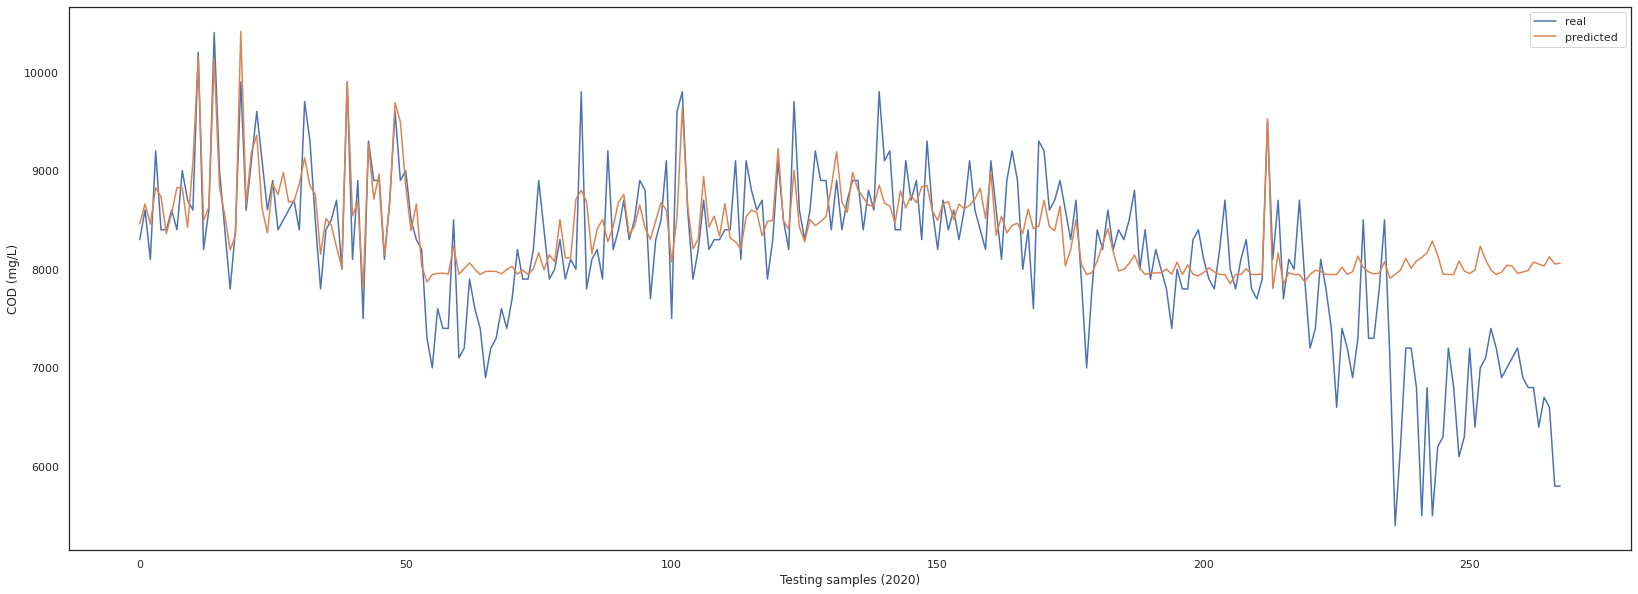

In [ ]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

In [ ]:
class Ensemble3:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
  

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
 
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 16, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons/2, activation='relu', input_dim = self.X_train.shape[1]))
    self.model.add(Dense(neurons, activation='relu'))
    self.model.add(Dense(3, activation='softmax'))

    print(self.Y_train.shape)
    print(self.X_train.shape)

    self.model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df_test['model1'] - self.df_test['target'])
    model2 = abs(self.df_test['model2'] - self.df_test['target'])
    model3 = abs(self.df_test['model3'] - self.df_test['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Yt = pd.get_dummies(temp)   

    self.Y_test = self.Yt
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    print(self.X_test, self.Y_train)

    self.score = self.model.evaluate(self.X_test, self.Y_test)
    self.prediction = self.model.predict(self.X_test)
    
    self.full_prediction = np.zeros(len(self.prediction))
    self.selection = pd.DataFrame(self.prediction).idxmax(axis=1)

    
    for i in range(len(self.prediction)):
      self.full_prediction[i] = self.df_test[f'model{int(self.selection[i])+1}'][i]
    # print(self.full_prediction)

    self.Ys_test = self.df_test['target']
    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('MAPEsci: ',mean_absolute_error(self.Ys_test, self.full_prediction)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('R2: ',r2_score(self.Ys_test, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Ys_test, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Ys_test, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

     0  1  2
0    0  0  1
1    0  1  0
2    1  0  0
3    0  1  0
4    1  0  0
..  .. .. ..
263  1  0  0
264  1  0  0
265  1  0  0
266  1  0  0
267  1  0  0

[268 rows x 3 columns]
(268, 3)
(268, 4)
Epoch 1/50
8/8 [==============================] - 1s 34ms/step - loss: 1.1066 - accuracy: 0.3029 - val_loss: 1.0182 - val_accuracy: 0.5926
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0911 - accuracy: 0.3485 - val_loss: 1.0215 - val_accuracy: 0.5926
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0797 - accuracy: 0.3444 - val_loss: 1.0283 - val_accuracy: 0.5926
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0692 - accuracy: 0.3983 - val_loss: 1.0366 - val_accuracy: 0.5926
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0607 - accuracy: 0.3983 - val_loss: 1.0477 - val_accuracy: 0.5926
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 1.0531 - accuracy: 0.4564 - val_loss: 1.0

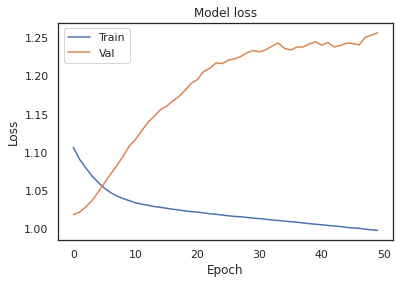

In [ ]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

     BT_C_MVLSS    model1    model2    model3
0      0.272312  1.336661  0.508886  0.550589
1      0.153453  0.706130  0.674695  0.436745
2      0.510030  0.385820  0.424680  0.713775
3     -0.084266  0.071609  0.833011  0.130344
4      1.223185  0.234215  0.556014  1.454289
..          ...       ...       ...       ...
263   -1.629435 -1.764670 -1.125121 -1.940368
264   -2.104872 -2.314082 -1.911566 -1.982614
265   -1.748295 -2.499095 -1.414891 -1.853589
266   -1.867154 -1.865906 -1.294802 -2.033599
267   -2.818027 -3.000803 -2.679053 -2.654279

[268 rows x 4 columns]      0  1  2
0    0  0  1
1    0  1  0
2    1  0  0
3    0  1  0
4    1  0  0
..  .. .. ..
263  1  0  0
264  1  0  0
265  1  0  0
266  1  0  0
267  1  0  0

[268 rows x 3 columns]
9/9 [==============================] - 0s 3ms/step - loss: 1.0228 - accuracy: 0.4552
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(4.268534360285301, shape=(), dtype=float64)
MAPEsci:  33085.228581215015
MAPE:  4.2685343602853
R2:  0.72708

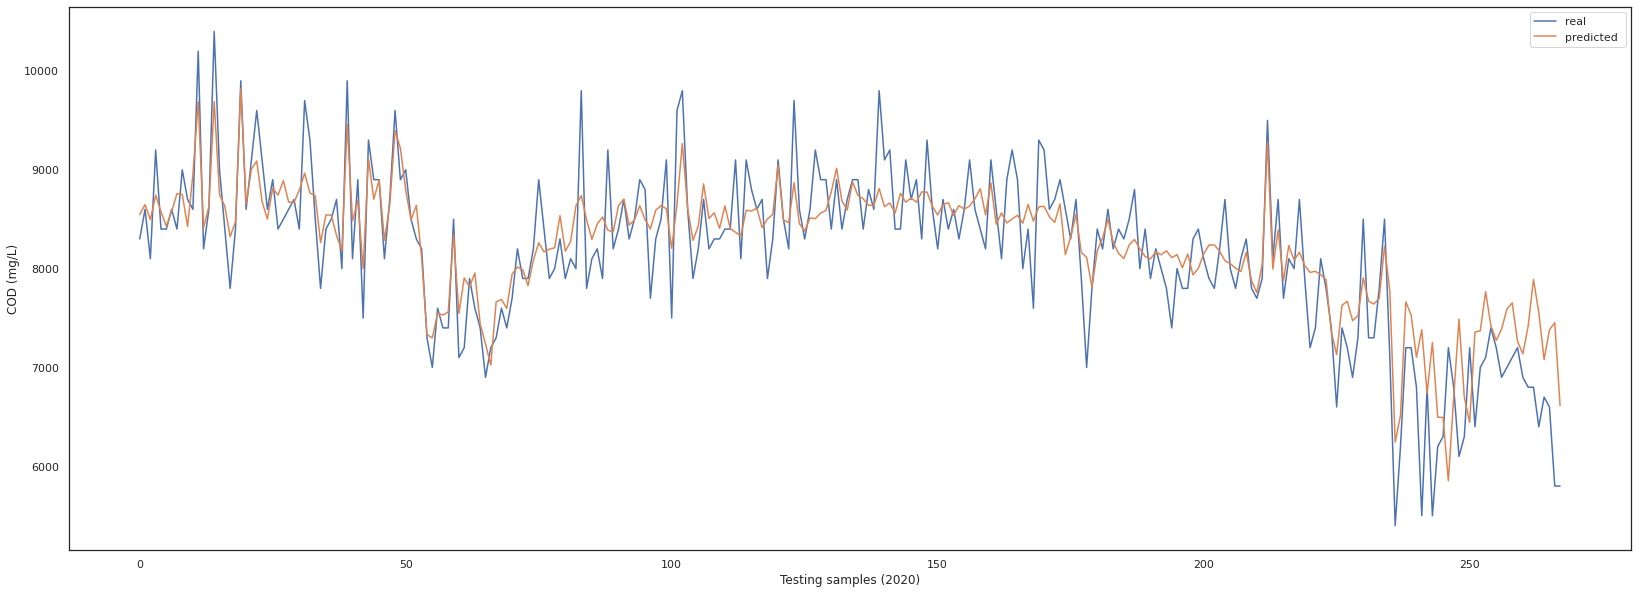

In [ ]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(1)

268

## Testing


*** ANN estimation ***
MAPE:  10.332900028544067
R2:  -0.40544358230631605
RMSE:  627.0727690103996


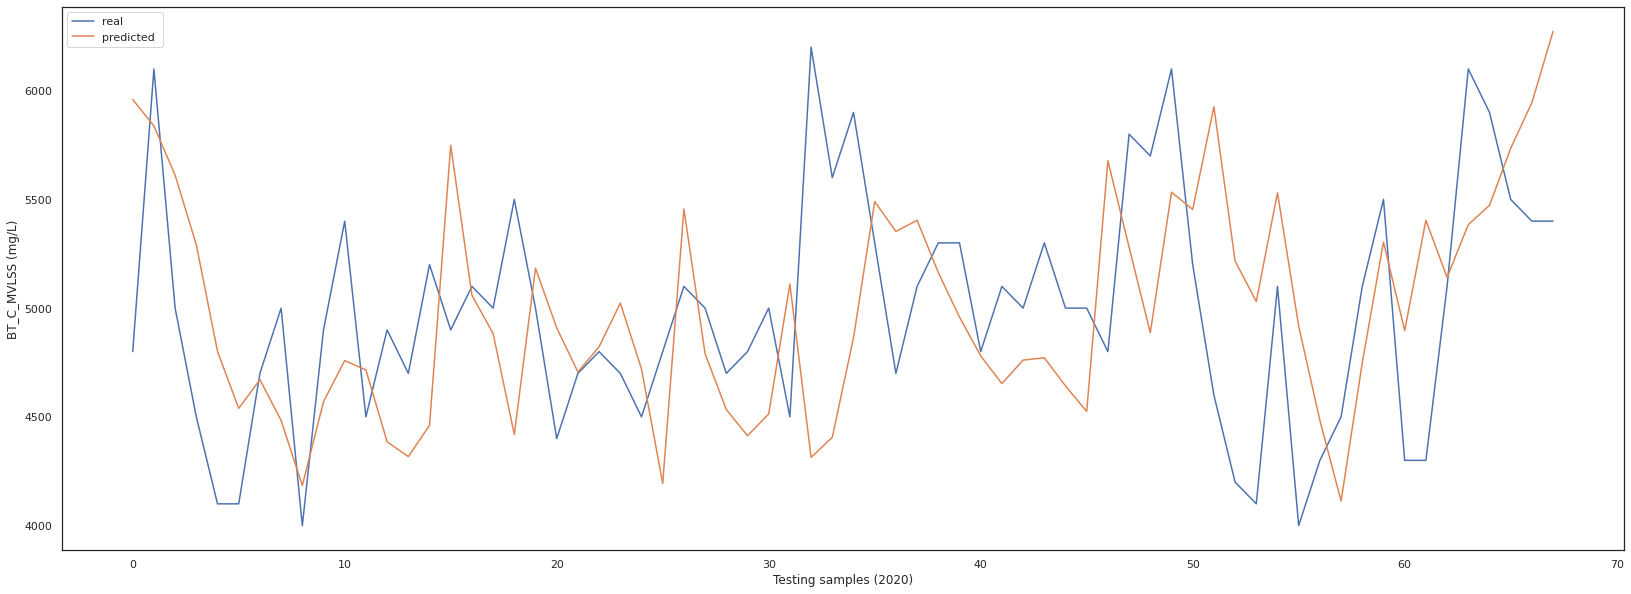

(68,)

In [ ]:
app1.testing(dataset.iloc[-(cut_off + 5):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  28.471625294739734
R2:  -7.437541908565269
RMSE:  1536.4527348658899


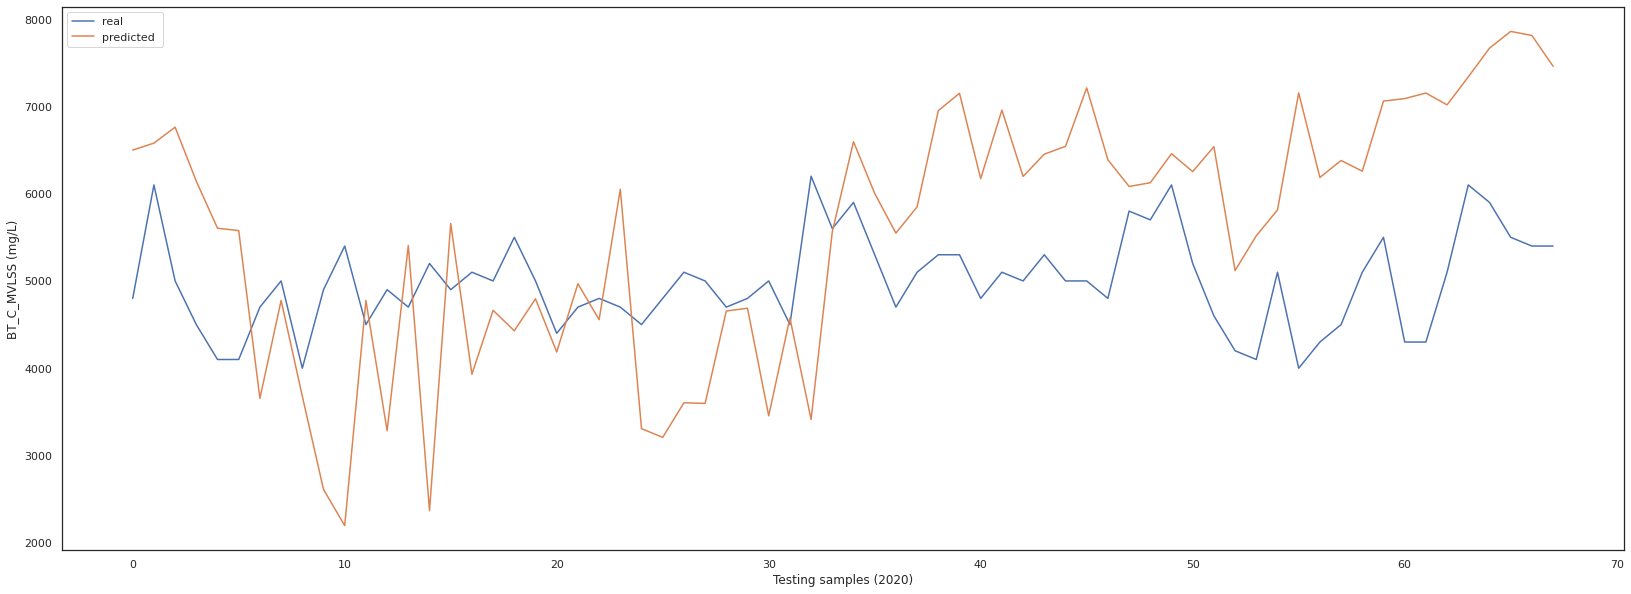

(68, 1)

In [ ]:
app2.testing(dataset.iloc[-(cut_off + 7):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  31.825359564070173
R2:  -8.20312440344565
RMSE:  1604.644676523383


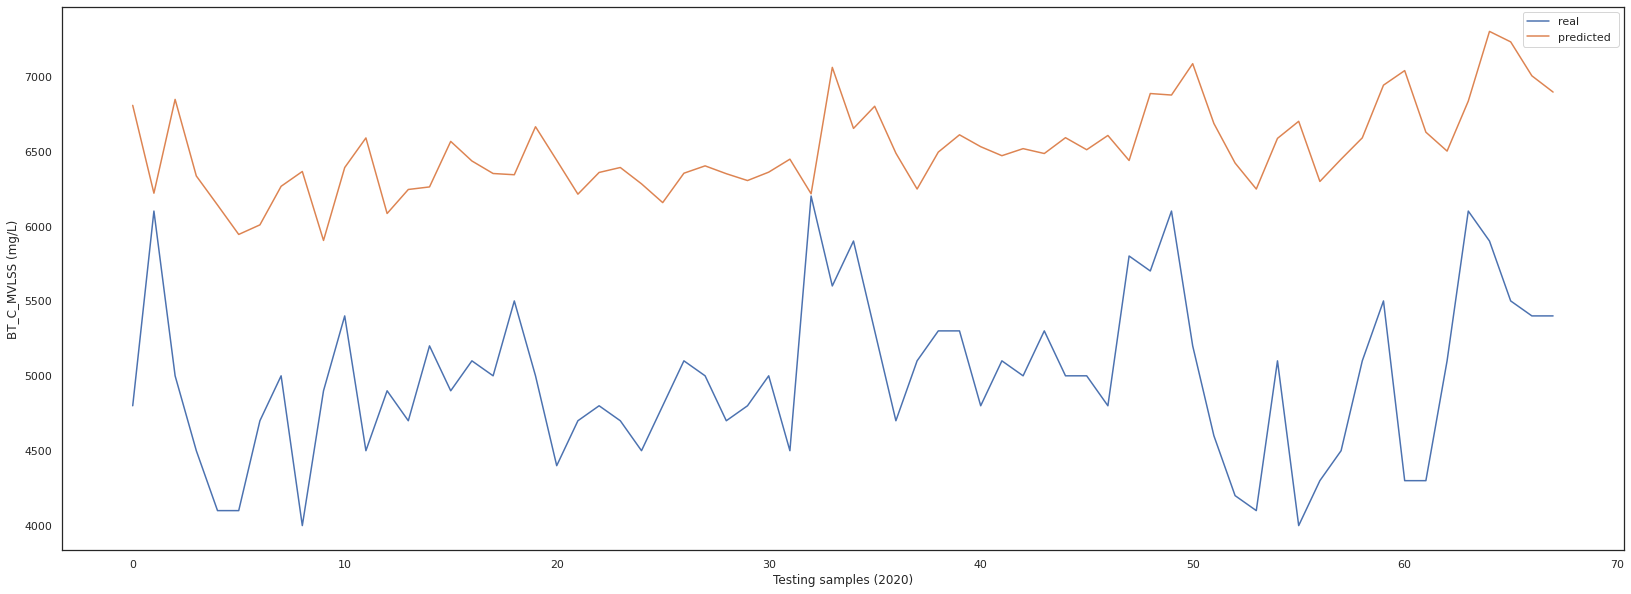

(68,)

In [ ]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  17.814057511437692
R2:  -2.6484799735867215


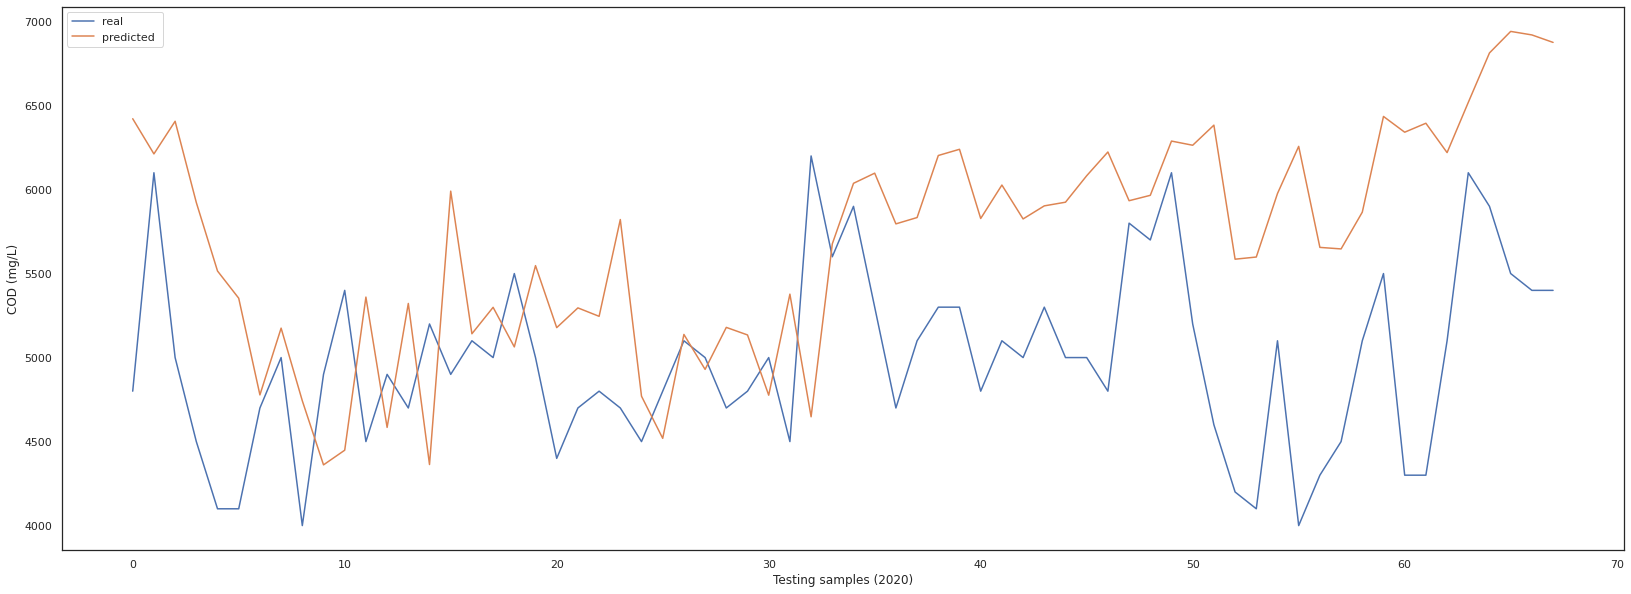

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[24.705606  31.84092   29.695087  18.454836   9.184417   9.296167
 41.804504  19.0255    48.066826  64.120346  76.003296  21.284084
 52.587337   8.761153  73.35998    9.507004  36.79171   21.267395
 28.773663  19.297863  32.44797   13.8012905 24.26783   15.316984
 51.36506   56.31002   40.162907  45.694294  22.705833  21.907259
 50.42729   22.628904  51.509876  10.12556   24.673288  12.721461
  8.330811  13.475537  36.210564  39.426723  16.04713   34.78749
 16.593842  22.484312  23.20078   40.38171   22.91547   16.357786
 12.808578  21.704903  15.370435  26.696127  11.328675   8.424207
 11.028037  38.526028  17.250788  19.08135   17.25128   35.24166
 33.567924  40.923885  37.755573  43.541927  47.75649   54.213436
 55.95094   49.239815 ], shape=(68,), dtype=float32)
MAPEsci:  136917.10420496325
MAPE:  29.820113686219607
R2:  -8.853776670479224
RMSE:  1660.3994882764712


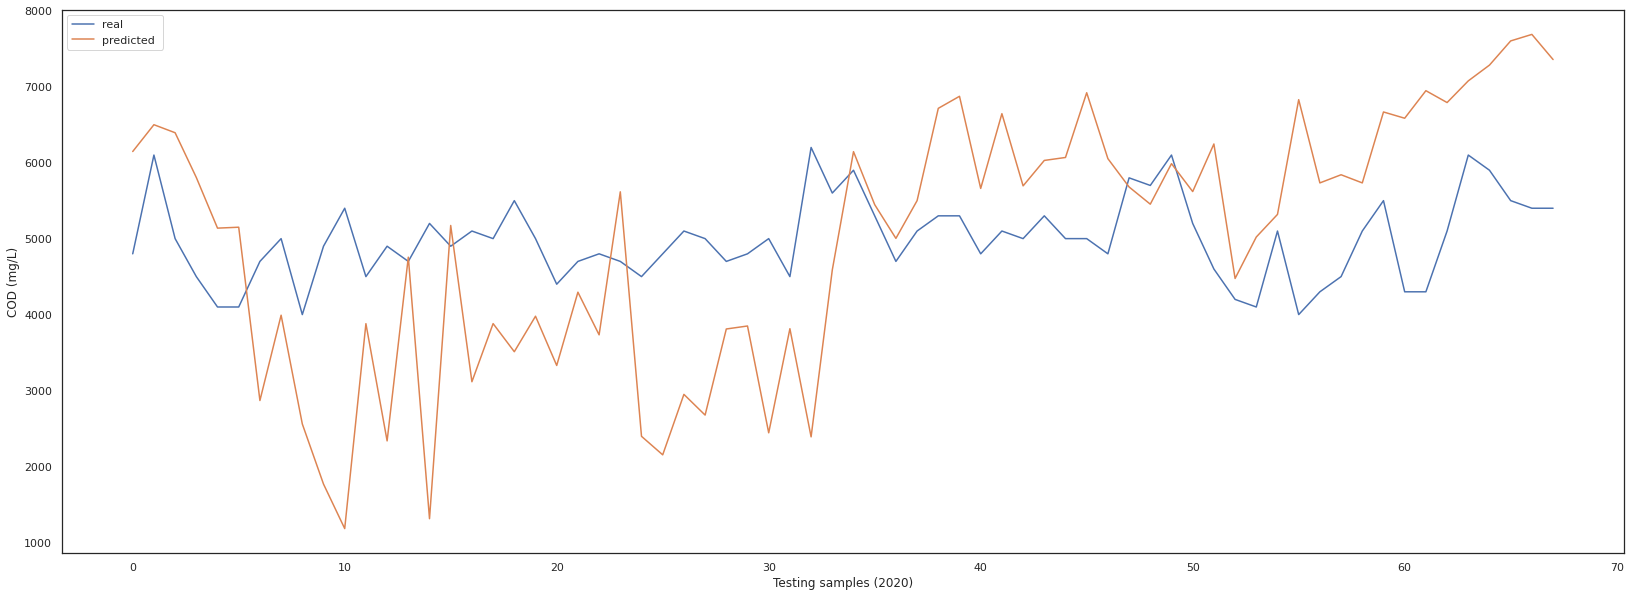

In [ ]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[63.368862 65.53952  67.60605  65.52684  66.36897  67.556015 63.219143
 65.169525 63.617306 63.24963  63.623093 64.55024  63.121616 69.81467
 63.70108  63.070633 63.13303  62.73046  64.22993  62.646    63.0476
 65.51948  63.747322 67.49056  63.31098  63.725178 62.563087 62.897533
 64.36354  65.6443   63.68847  62.775208 63.84809  74.346306 73.06961
 64.59642  63.475437 64.95739  71.37777  75.05775  71.03851  76.46947
 71.44122  72.55452  74.7674   81.46895  65.85204  66.28224  71.784966
 67.290634 68.084404 65.191475 64.47126  66.60247  67.19501  76.28782
 73.49431  78.90824  72.88952  73.70118  78.36186  71.72478  72.677505
 73.65708  83.386215 81.89456  74.67218  66.6484  ], shape=(68,), dtype=float32)
MAPE:  68.23739563830638
R2:  -39.19388872479515
RMSE:  3353.445451018833


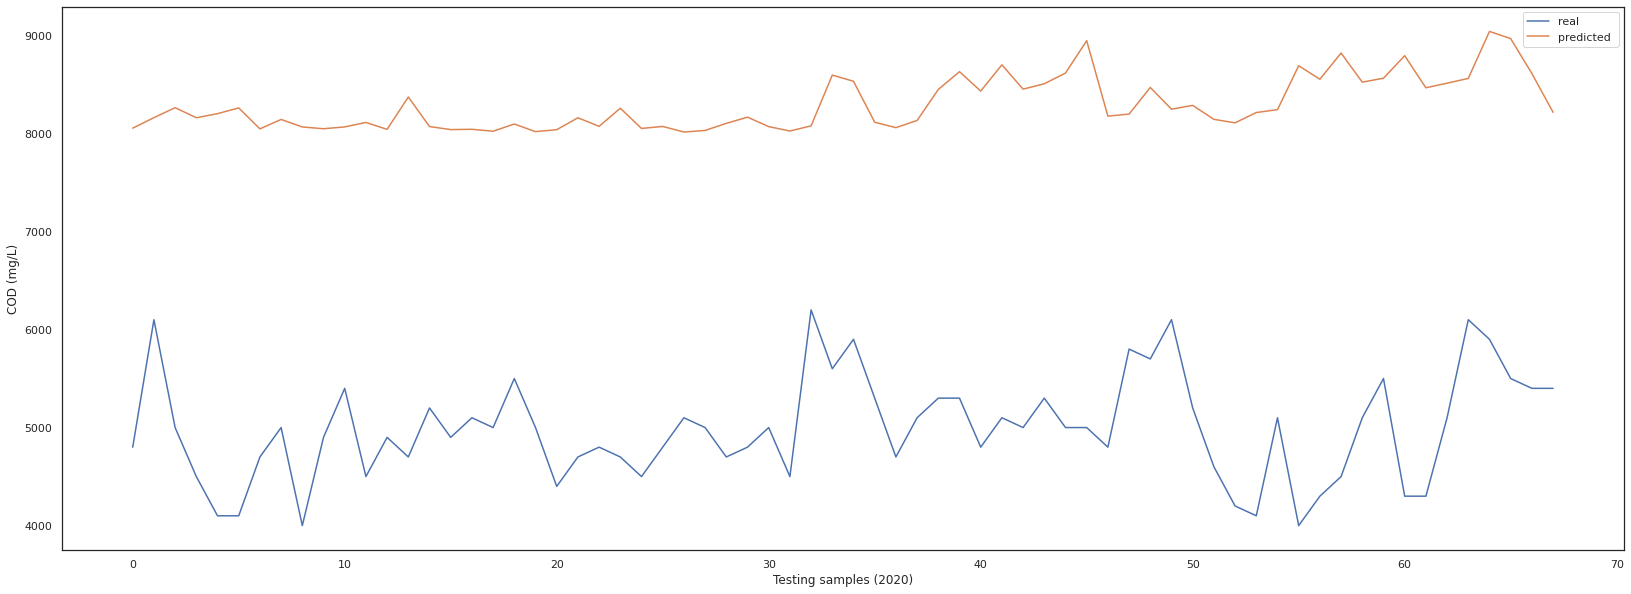

In [ ]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

    BT_C_MVLSS    model1    model2    model3
0    -2.580309 -3.270468 -2.867434 -2.591382
1    -4.006619 -3.449745 -2.736307 -3.728617
2    -2.461450 -3.784050 -2.434307 -2.514244
3    -3.768901 -4.256673 -3.456494 -3.505475
4    -4.363197 -4.980498 -4.344406 -3.881653
..         ...       ...       ...       ...
63   -3.650042 -4.119847 -1.485033 -2.536345
64   -2.461450 -3.988766 -0.941834 -1.634084
65   -2.699168 -3.601850 -0.625361 -1.769668
66   -3.174605 -3.291381 -0.701962 -2.209105
67   -3.293464 -2.808002 -1.283583 -2.419311

[68 rows x 4 columns]      0  1  2
0    0  0  1
1    0  1  0
2    1  0  0
3    0  1  0
4    1  0  0
..  .. .. ..
263  1  0  0
264  1  0  0
265  1  0  0
266  1  0  0
267  1  0  0

[268 rows x 3 columns]
3/3 [==============================] - 0s 4ms/step - loss: 1.5314 - accuracy: 0.1765
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(26.512194797431025, shape=(), dtype=float64)
MAPEsci:  130205.80336626837
MAPE:  26.512194797431025
R2:  -7.4375419085652

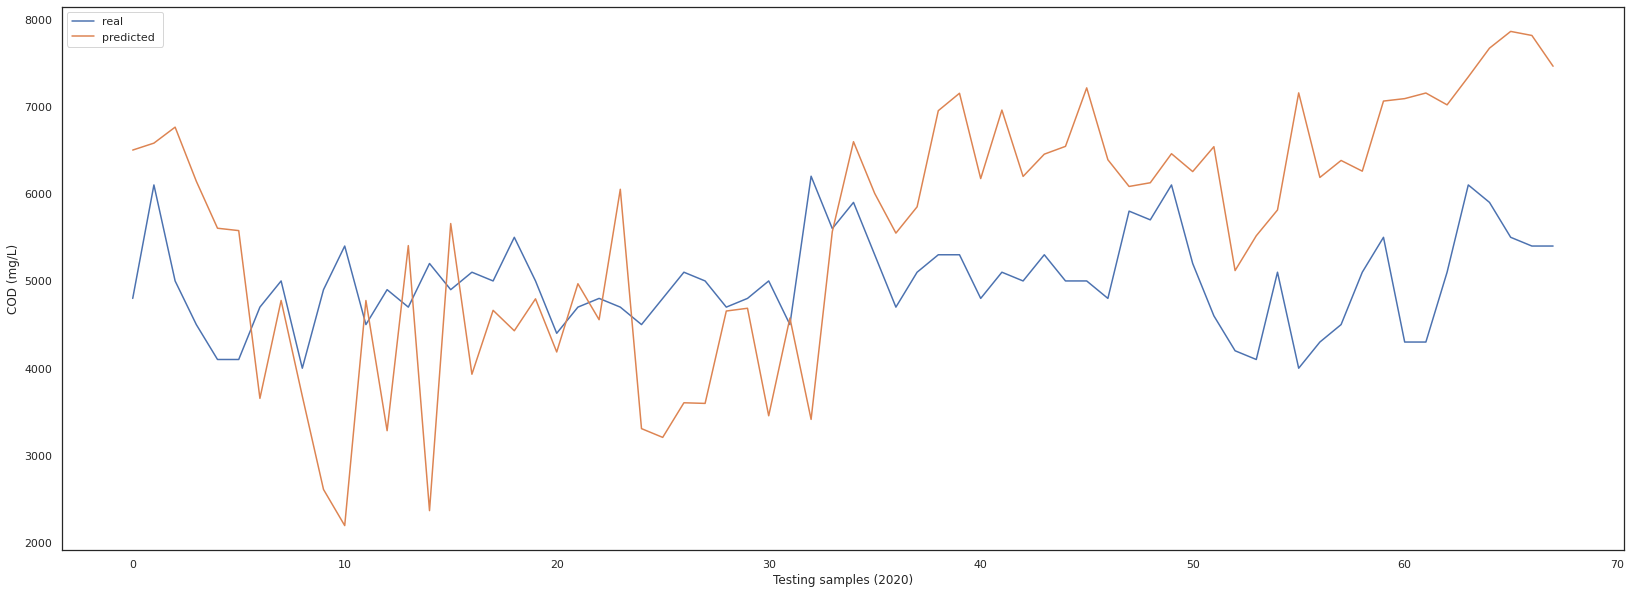

In [ ]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(3)

0

# EQ_COD

In [ ]:
active_target = "EQ_COD"
dataset = dataset1.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        343 non-null    object 
 1   Flow_to_EQ  343 non-null    object 
 2   Flow_efl    343 non-null    float64
 3   BT_C_MLSS   343 non-null    float64
 4   BT_C_MVLSS  343 non-null    float64
 5   BT_N_MLSS   343 non-null    float64
 6   BT_N_MVLSS  343 non-null    float64
 7   D_SS        343 non-null    float64
 8   EQ_N        343 non-null    float64
 9   BT_C_N      343 non-null    float64
 10  BT_N_N      343 non-null    float64
 11  D_N         343 non-null    float64
 12  OxT_PH_PM   343 non-null    float64
 13  EQ_PH       343 non-null    float64
 14  BT_N_PH     343 non-null    float64
 15  D_PH        343 non-null    float64
 16  BT_N_DO     343 non-null    float64
 17  BT_C_DO     343 non-null    float64
 18  Clari_DO    343 non-null    float64
 19  F/M         343 non-null    f

## Approach 1

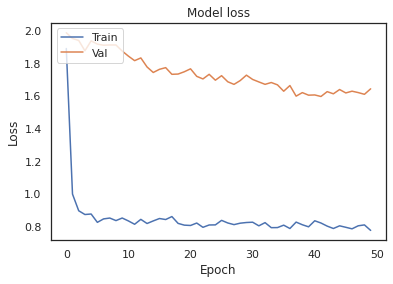

*** ANN estimation ***
MAPE:  8.600142041981174
R2:  0.5755559494873499
RMSE:  36.960219315779625


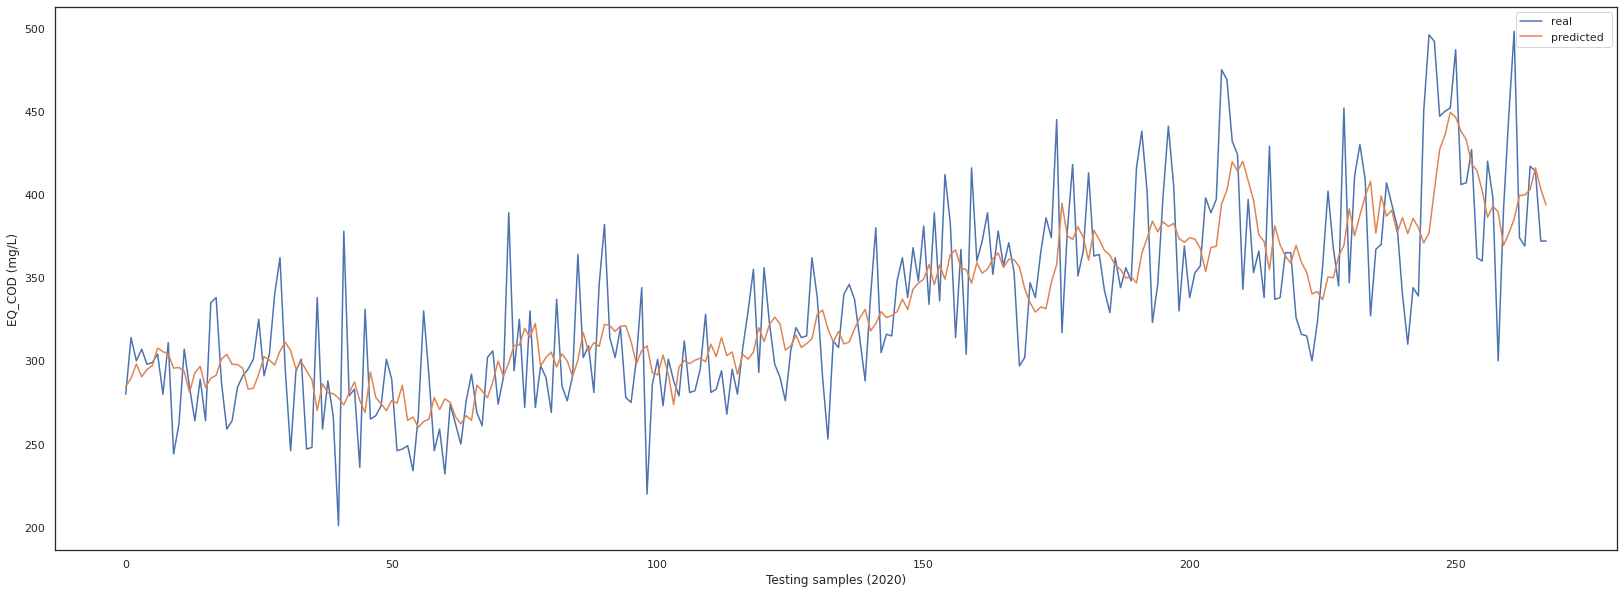

(268,)

In [ ]:
cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[2:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

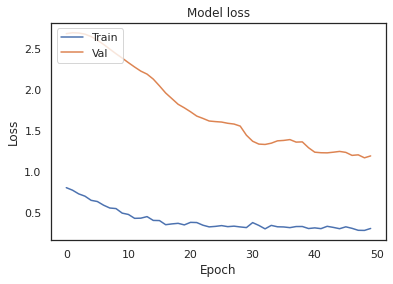

*** LSTM estimation ***
MAPE:  16.067843577788118
R2:  0.6366977068428824
RMSE:  34.194667407782276


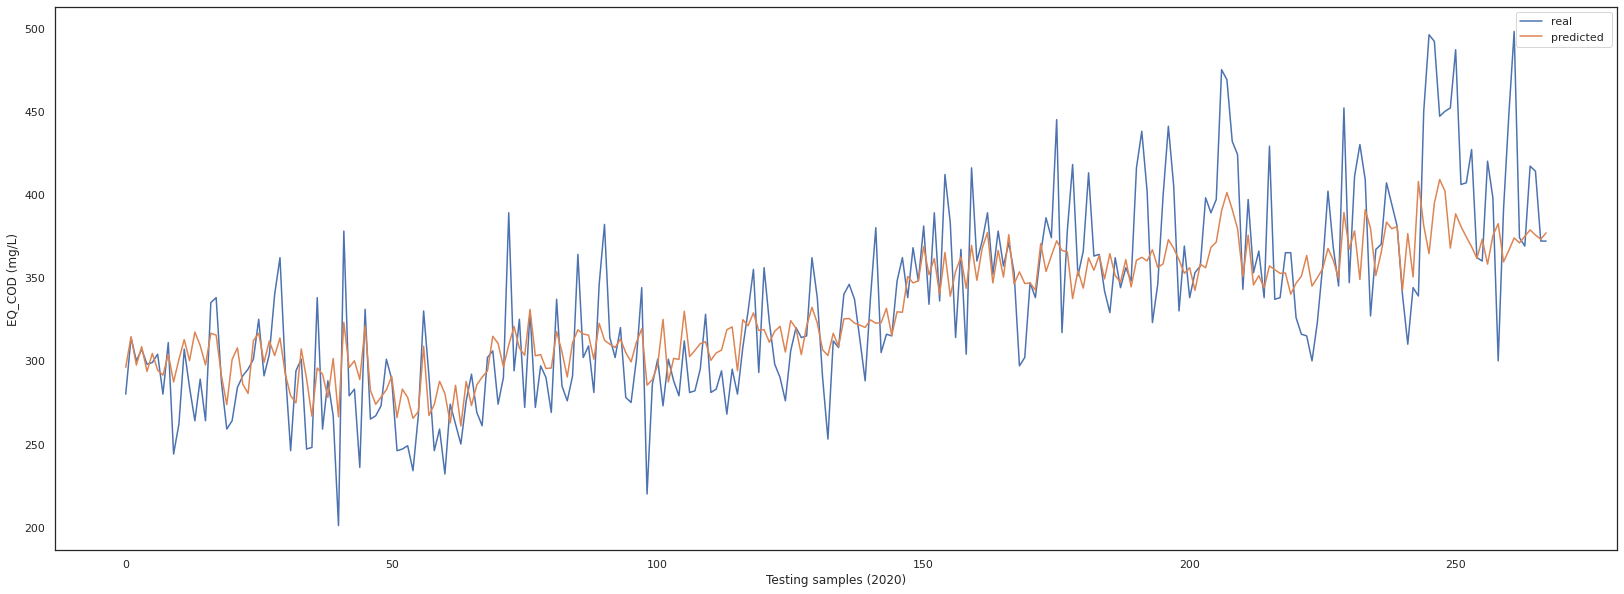

(268, 1)

In [ ]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=7)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  8.491742208199778
R2:  0.5900949513925617
RMSE:  36.321681686626846


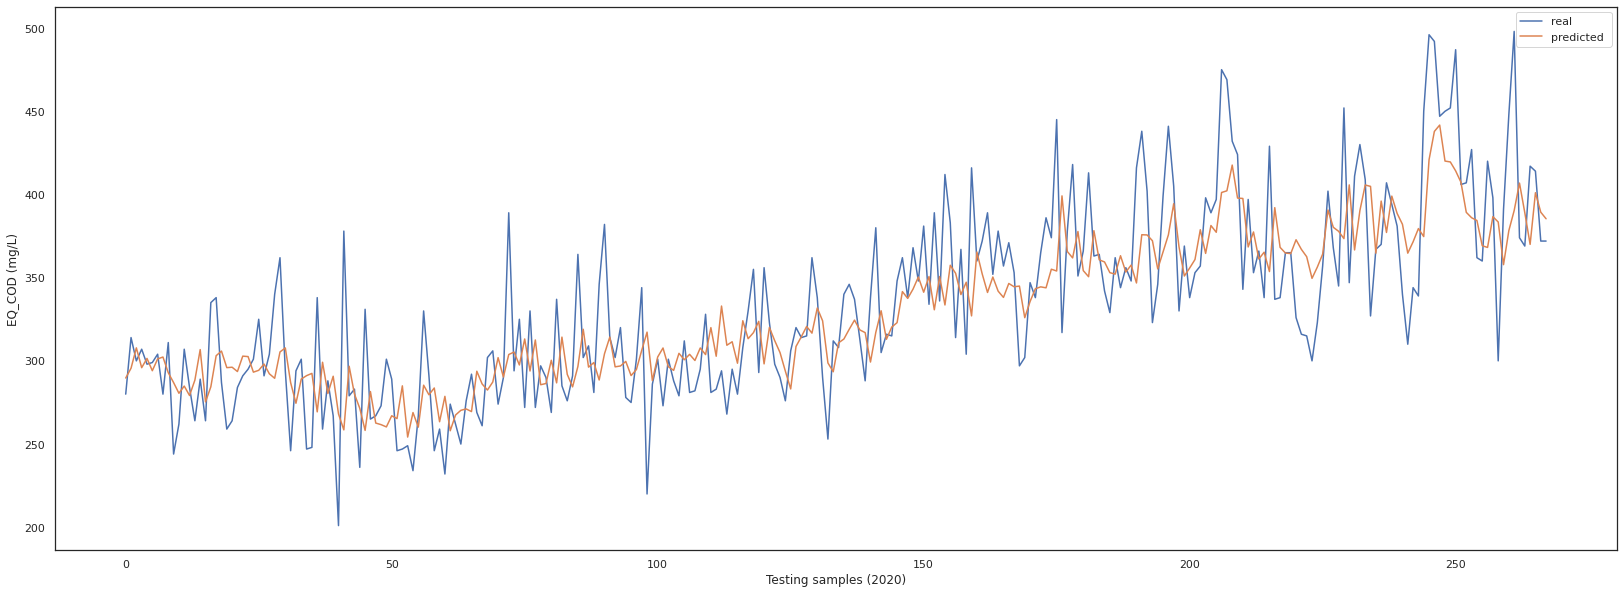

(268,)

In [ ]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

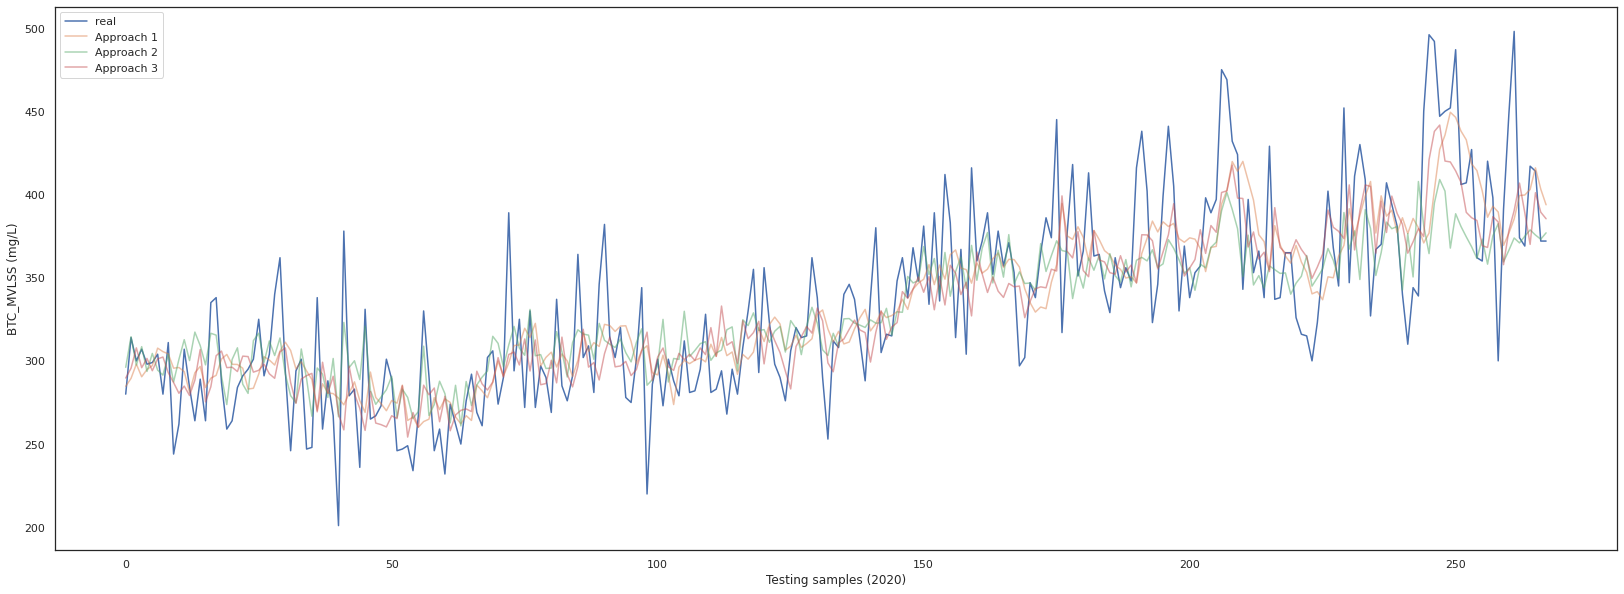

In [ ]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [ ]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0       870.524306
1       899.594914
2       903.362519
3       894.867739
4       889.941578
          ...     
263    1163.610480
264    1151.732615
265    1192.685187
266    1165.664011
267    1156.135023
Length: 268, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  8.376192977027172
R2:  0.5962917523817778
RMSE:  36.04608690111263


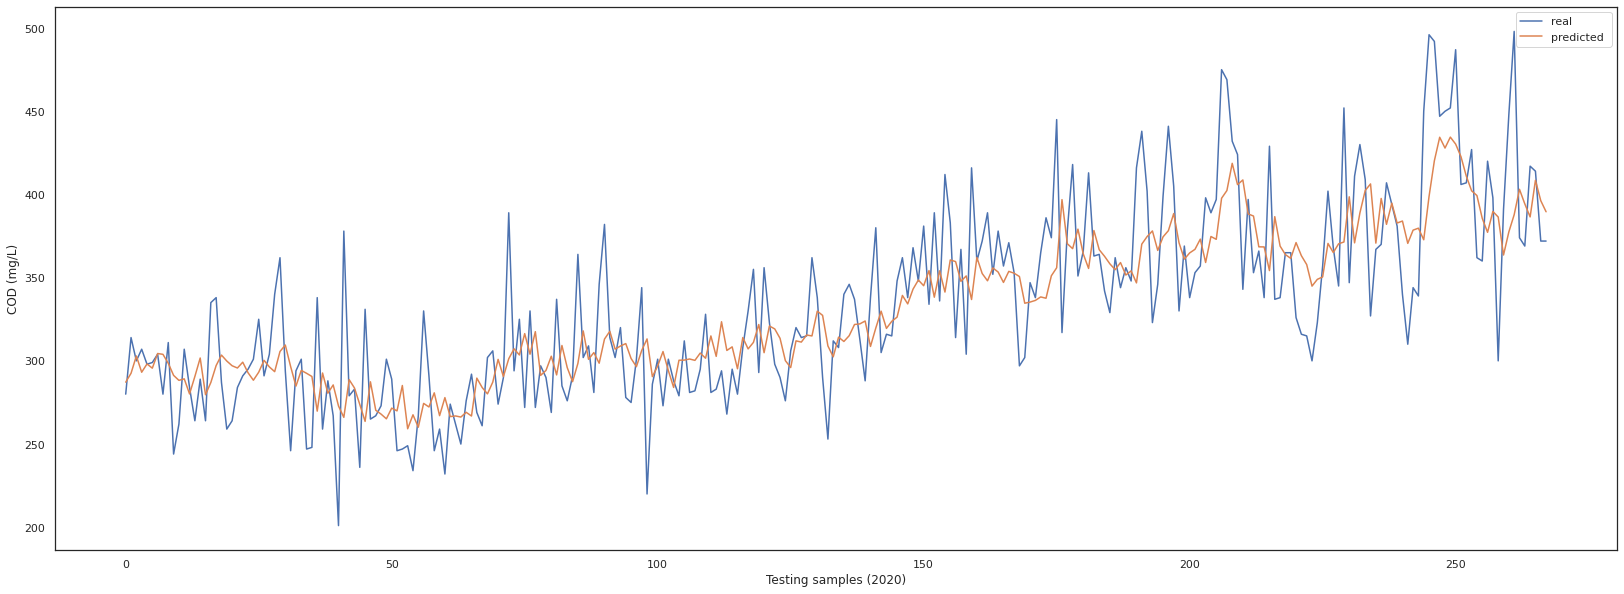

In [ ]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  7.886112541764276
R2:  0.6322919572605569
RMSE:  34.40138114484932


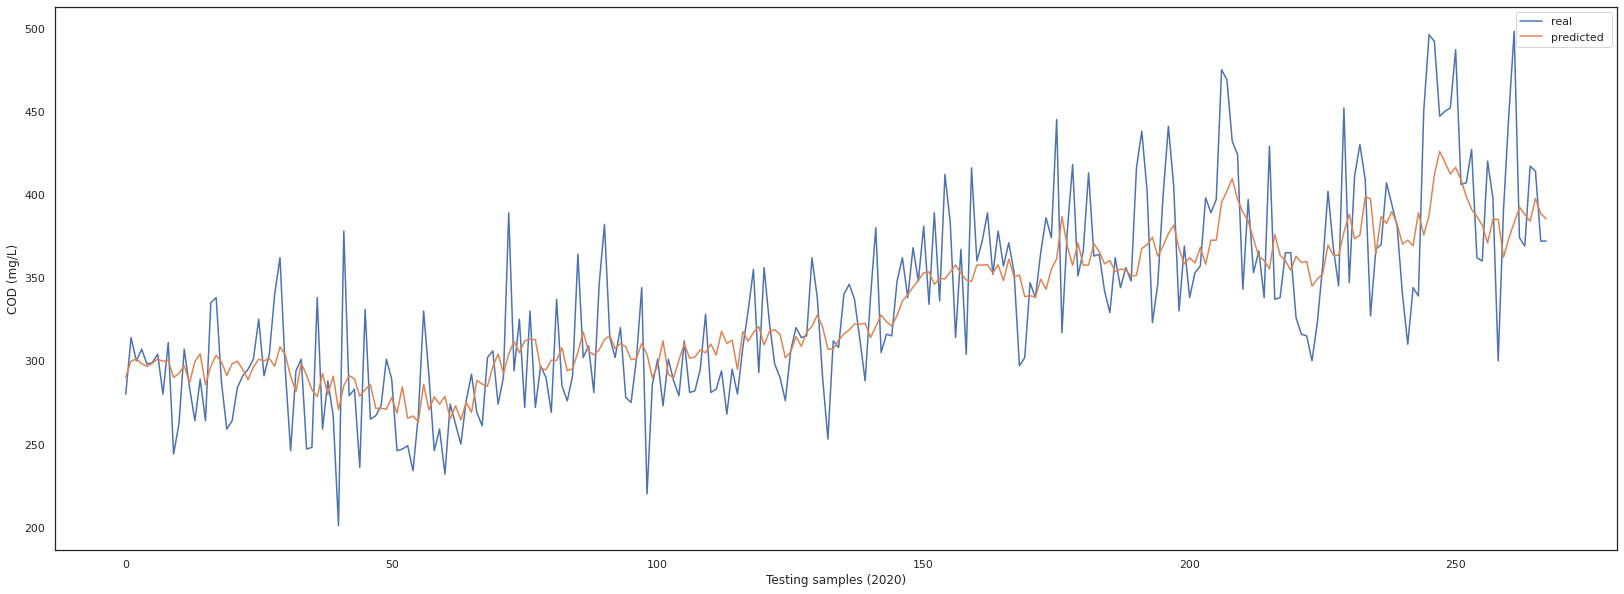

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

Epoch 1/50
8/8 [==============================] - 1s 26ms/step - loss: 1.0946 - MAPE: 138.2202 - val_loss: 1.7758 - val_MAPE: 100.7132
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0296 - MAPE: 134.7483 - val_loss: 1.6470 - val_MAPE: 98.2129
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.9687 - MAPE: 131.2436 - val_loss: 1.5217 - val_MAPE: 96.7319
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.9154 - MAPE: 129.0014 - val_loss: 1.4081 - val_MAPE: 95.4854
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8671 - MAPE: 126.5731 - val_loss: 1.3066 - val_MAPE: 94.3526
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8244 - MAPE: 125.8213 - val_loss: 1.2146 - val_MAPE: 93.3925
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.7857 - MAPE: 125.0573 - val_loss: 1.1360 - val_MAPE: 93.0958
Epoch 8/50
8/8 [==============================] - 0s 5ms/step - los

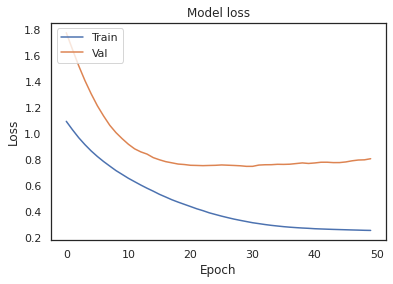

In [ ]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[14.872111  13.608191  14.634707  13.953757  15.120869  14.405809
 15.449236  15.682419  14.628903  16.275343  14.954938  13.703985
 14.659555  13.549974  13.90682   15.059614  13.552582  13.542377
 15.489199  18.004923  14.667271  14.134823  15.802327  15.267994
 13.641231  13.562486  14.895426  13.81291   14.601137  13.766262
 15.648415  17.880285  18.526358  14.231779  15.854976  18.476282
 14.989124  14.873108  17.152197  14.326387  19.31513   13.59982
 14.427336  14.808248  15.865597  13.565548  17.046276  18.33551
 17.519194  16.769136  15.773918  19.351713  16.50076   17.387293
 18.86236   18.274593  13.517382  17.327093  17.481264  16.033827
 16.745615  20.259663  16.050049  19.025717  15.700708  17.540989
 15.844795  15.483898  15.065021  13.587141  13.923942  15.014926
 13.966586  13.539238  14.364195  14.6391    13.631563  14.749874
 14.574878  15.56996   15.260328  13.556192  14.121406  15.91852
 13.767794  13.548549  13.7

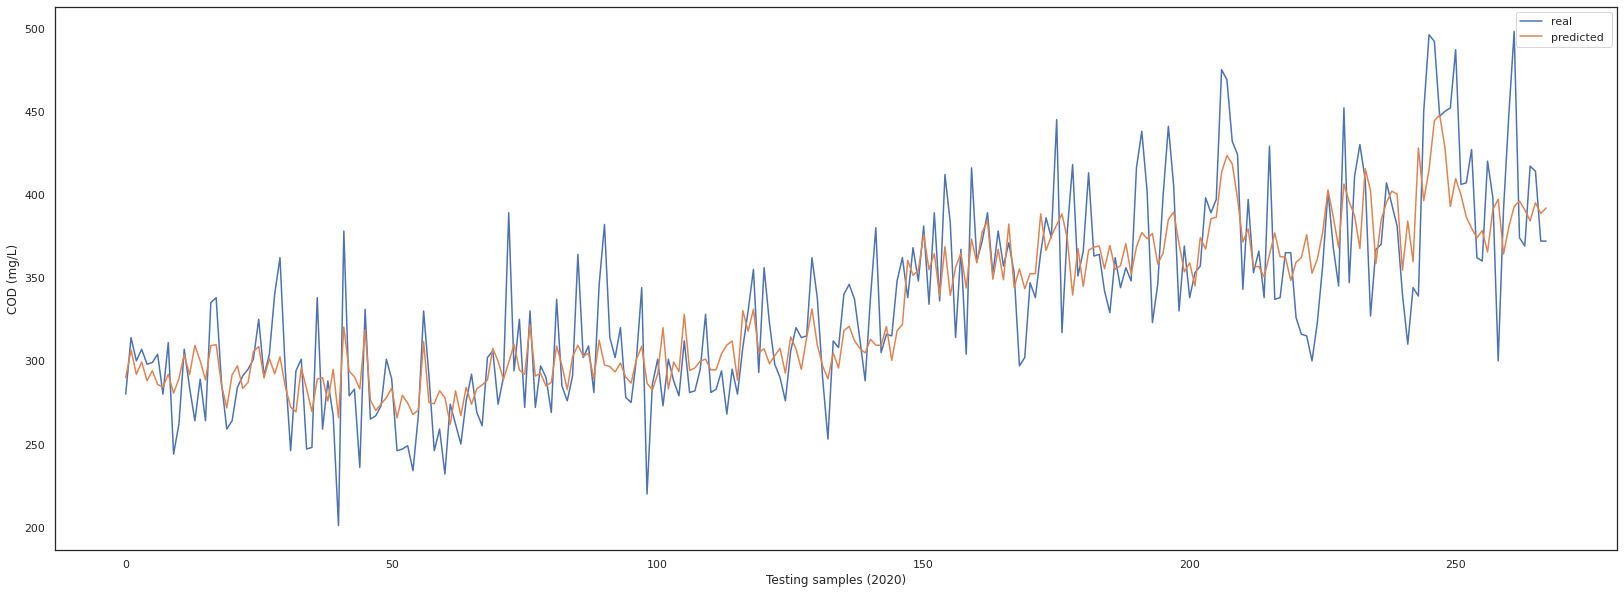

In [ ]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


Epoch 1/50
8/8 [==============================] - 1s 27ms/step - loss: 0.6084 - MAPE: 202.4346 - val_loss: 1.3147 - val_MAPE: 84.3829
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5655 - MAPE: 199.8492 - val_loss: 1.1626 - val_MAPE: 79.9465
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5357 - MAPE: 196.7203 - val_loss: 1.0485 - val_MAPE: 77.0071
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5133 - MAPE: 196.0045 - val_loss: 0.9575 - val_MAPE: 74.7325
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.4950 - MAPE: 195.3985 - val_loss: 0.8968 - val_MAPE: 73.6968
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.4829 - MAPE: 196.1857 - val_loss: 0.8512 - val_MAPE: 72.8086
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.4729 - MAPE: 196.0100 - val_loss: 0.8229 - val_MAPE: 72.2142
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss

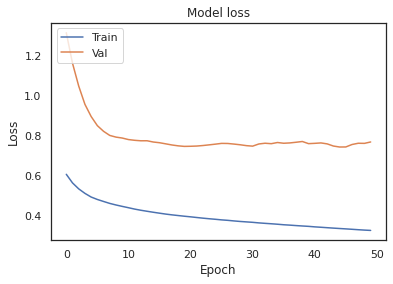

In [ ]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[15.138133  13.81332   14.157724  14.465697  14.702196  14.292087
 13.832134  14.14913   13.693512  16.56726   13.820799  13.779676
 17.937622  13.97354   13.507249  17.168774  13.870552  14.7584305
 15.615313  15.168481  13.590264  13.592982  14.213504  15.670226
 14.760791  14.166105  14.759244  13.806245  14.816238  13.983252
 16.420633  15.655533  15.483099  14.227819  15.688997  14.839665
 17.21174   17.280704  16.828611  15.58536   20.547585  14.122918
 20.597286  15.600994  19.098711  15.929501  19.165533  20.34819
 20.723751  21.587734  20.877924  23.224602  14.958104  21.927984
 20.858456  21.5591    16.186281  25.444359  19.129448  18.49525
 17.254858  20.193077  20.82266   22.839031  18.24173   22.367685
 16.051453  15.726816  15.824276  15.0677395 13.791488  14.522533
 13.605749  15.322161  13.587552  13.581674  13.603692  13.617868
 14.08668   14.861809  13.758607  13.66451   13.8608265 14.472169
 14.315203  13.59814   13

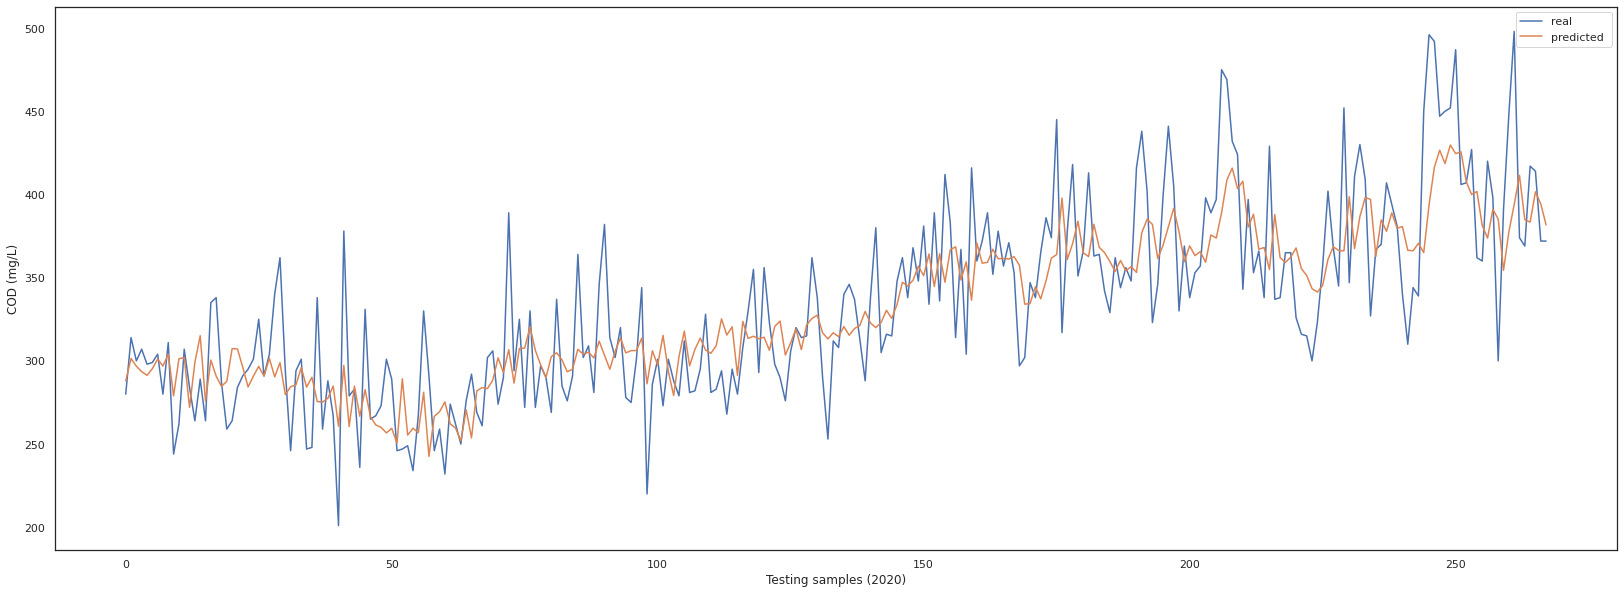

In [ ]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

     0  1  2
0    1  0  0
1    0  1  0
2    1  0  0
3    0  1  0
4    1  0  0
..  .. .. ..
263  0  1  0
264  1  0  0
265  1  0  0
266  0  1  0
267  0  1  0

[268 rows x 3 columns]
(268, 3)
(268, 4)
Epoch 1/50
8/8 [==============================] - 1s 35ms/step - loss: 1.1170 - accuracy: 0.3651 - val_loss: 1.1264 - val_accuracy: 0.2593
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 1.1039 - accuracy: 0.3900 - val_loss: 1.1406 - val_accuracy: 0.2963
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0936 - accuracy: 0.3983 - val_loss: 1.1539 - val_accuracy: 0.2963
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 1.0874 - accuracy: 0.4315 - val_loss: 1.1691 - val_accuracy: 0.2963
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 1.0804 - accuracy: 0.4523 - val_loss: 1.1825 - val_accuracy: 0.2963
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 1.0769 - accuracy: 0.4357 - val_loss: 1.1

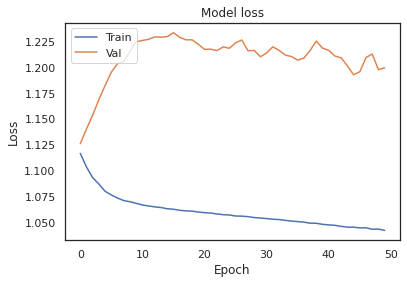

In [ ]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

       EQ_COD    model1    model2    model3
0   -0.981780 -1.103101 -0.995149 -0.942350
1   -0.929048 -0.993705 -0.457668 -0.804295
2   -0.331414 -0.797690 -0.956084 -0.516680
3   -0.577498 -0.972200 -0.632740 -0.796676
4   -0.454456 -0.871779 -1.067491 -0.666109
..        ...       ...       ...       ...
263  0.723234  1.521170  1.306010  1.391033
264  0.635347  1.597478  1.416893  0.944274
265  1.479065  1.893748  1.327033  1.673667
266  1.426332  1.601820  1.253218  1.398722
267  0.688079  1.387209  1.365052  1.305816

[268 rows x 4 columns]      0  1  2
0    1  0  0
1    0  1  0
2    1  0  0
3    0  1  0
4    1  0  0
..  .. .. ..
263  0  1  0
264  1  0  0
265  1  0  0
266  0  1  0
267  0  1  0

[268 rows x 3 columns]
9/9 [==============================] - 0s 2ms/step - loss: 1.0579 - accuracy: 0.4440
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(7.595263086565114, shape=(), dtype=float64)
MAPEsci:  2562.0523600394445
MAPE:  7.595263086565109
R2:  0.6358773180078291
RMSE:  34.

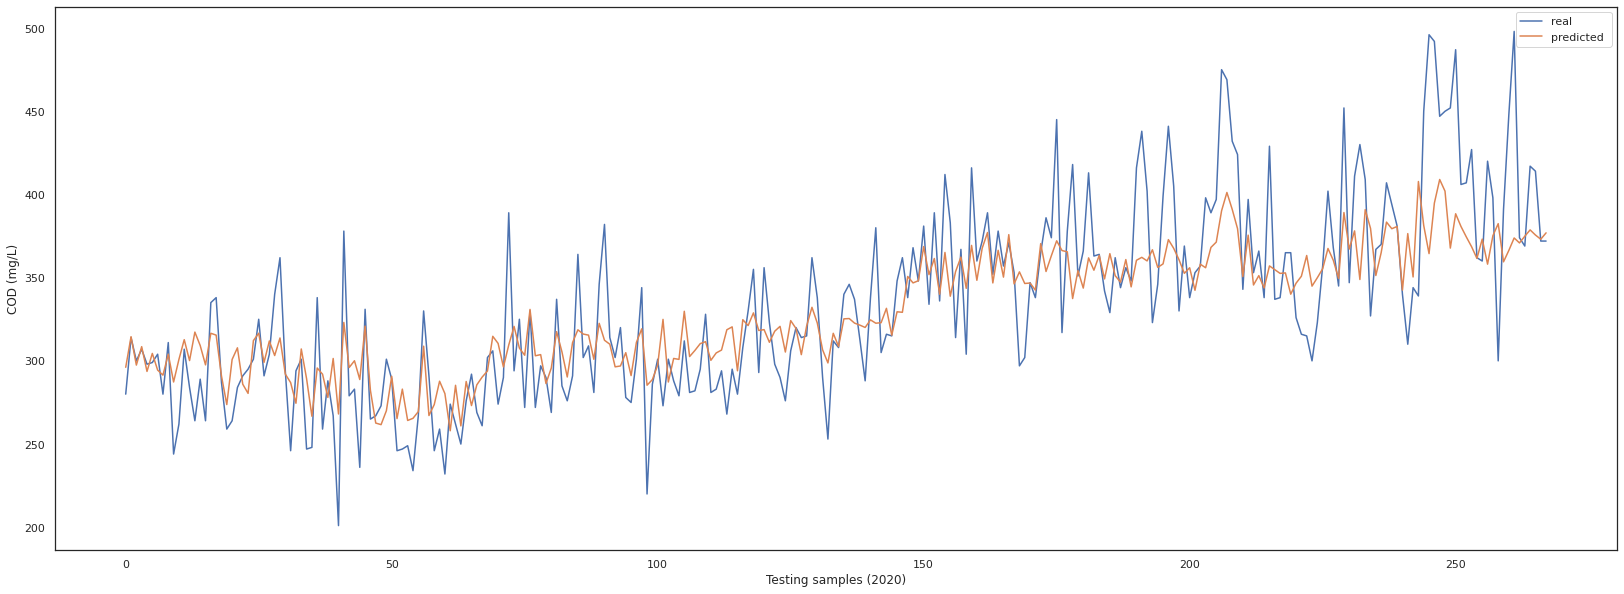

In [ ]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(1)

254

### Ensemble 4

In [ ]:
class Ensemble4:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[['model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    # self.Y = self.df['target']
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    # self.y_mean = self.Y.mean()
    # self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
    # self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
  

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target']
    # print(self.Xt)

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean


    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [ ]:
# ensemble_model4 = Ensemble4(dataset.iloc[:-135], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
# ensemble_model4.training()

## Testing


*** ANN estimation ***
MAPE:  6.214175803137678
R2:  -0.11949375295703679
RMSE:  30.897101259996635


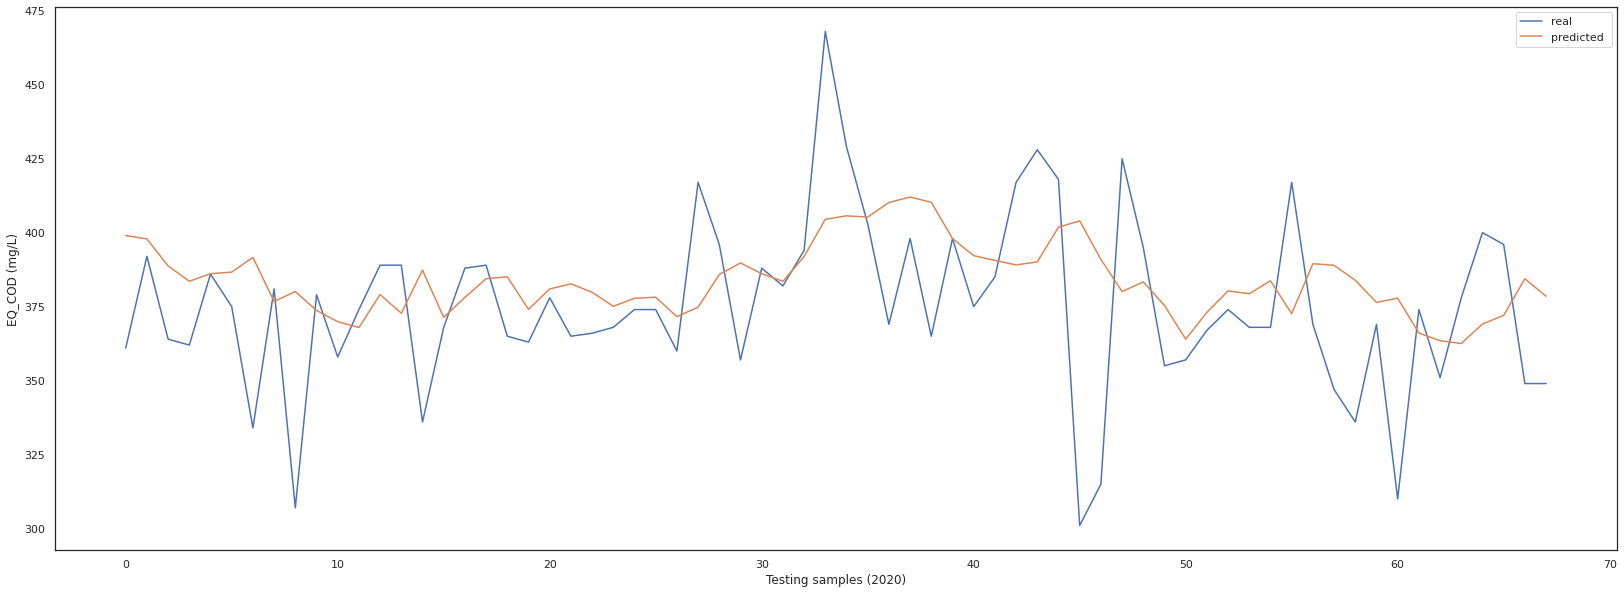

(68,)

In [ ]:
app1.testing(dataset.iloc[-(cut_off + 5):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  7.593516288863567
R2:  -0.3298048262826121
RMSE:  33.67447637765098


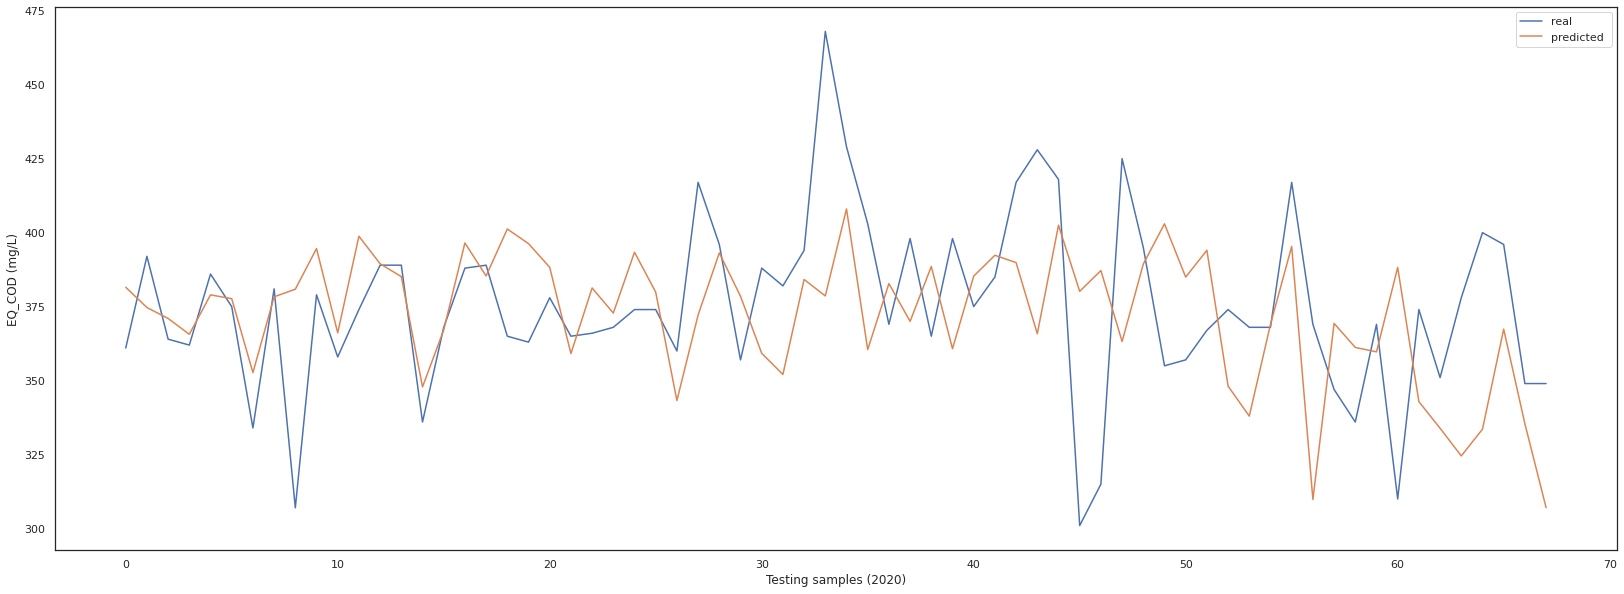

(68, 1)

In [ ]:
app2.testing(dataset.iloc[-(cut_off + 7):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  5.670749237290998
R2:  0.022310335400728243
RMSE:  28.87403051091999


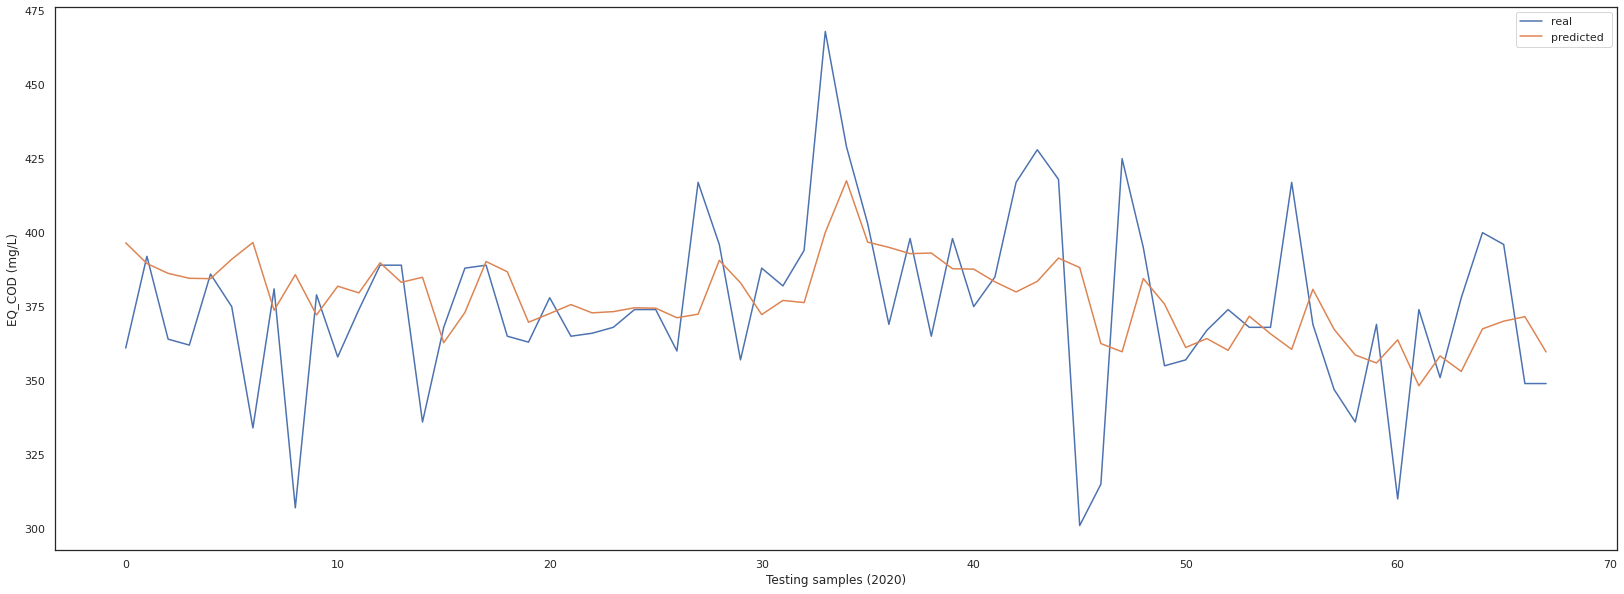

(68,)

In [ ]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  5.6798813065291185


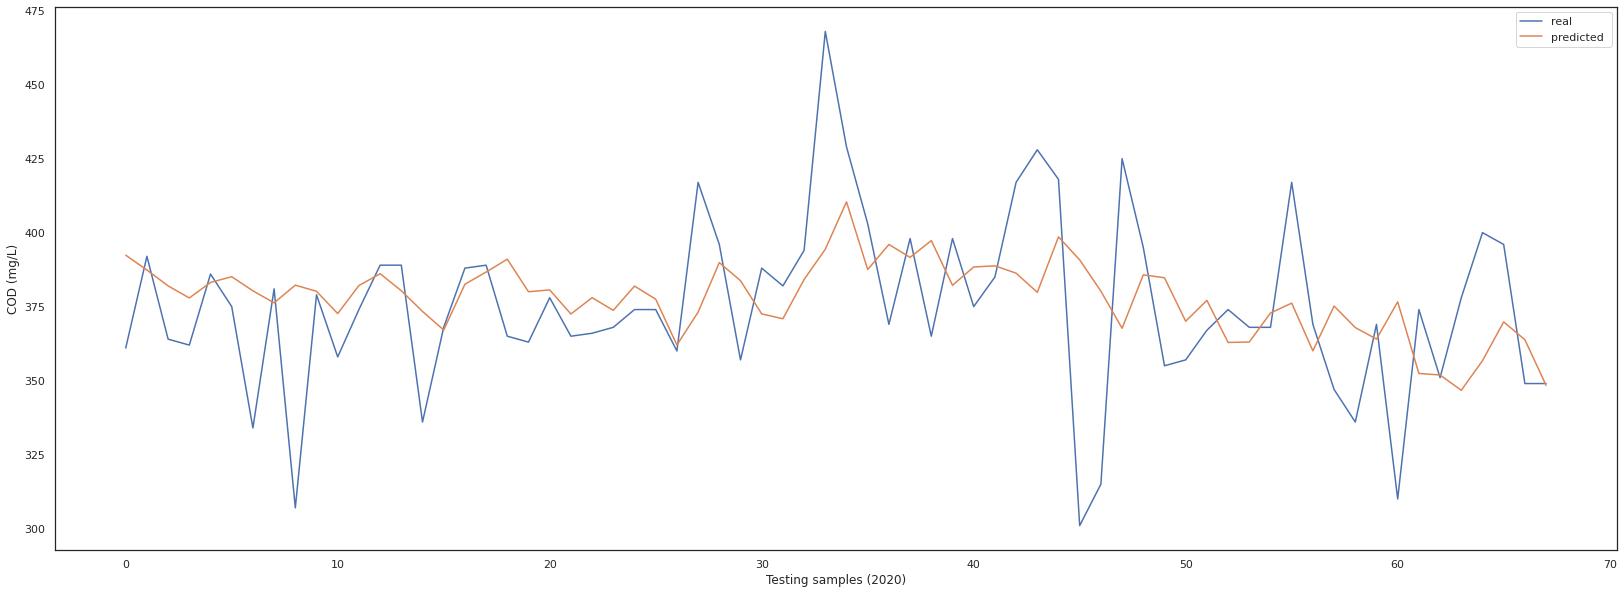

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 9.112876   7.2897854  6.771008   6.2464347  7.8372383  8.191469
  5.747045   7.1332893  8.486378  11.122127   6.373543  13.468665
 10.769276   9.58228    6.083199   5.7418847 11.332982   9.730484
 13.257445  11.331739   8.87779    5.7394075  7.427095   6.498973
 10.64844    7.380718   7.496876   6.39994   11.38062    7.5542154
  5.747467   6.0076857  7.8421407  8.700157  17.606712   6.0502305
  8.817641   6.618236   9.81159    5.849671   9.164914  10.237028
  9.386675   6.125044  12.936065   7.8632855  7.2649374  5.813011
  9.987962  13.675345   8.477539  10.353388   7.7187905  9.327577
  5.8038325 10.434183  12.600873   5.816336   6.0606503  6.236199
  8.4101515  9.937295  11.578482  14.048764  10.834509   5.9437265
  9.815764  15.327703 ], shape=(68,), dtype=float32)
MAPEsci:  2957.7860215130977
MAPE:  8.812423268780277
R2:  -0.5758301613609729
RMSE:  36.65739533781319


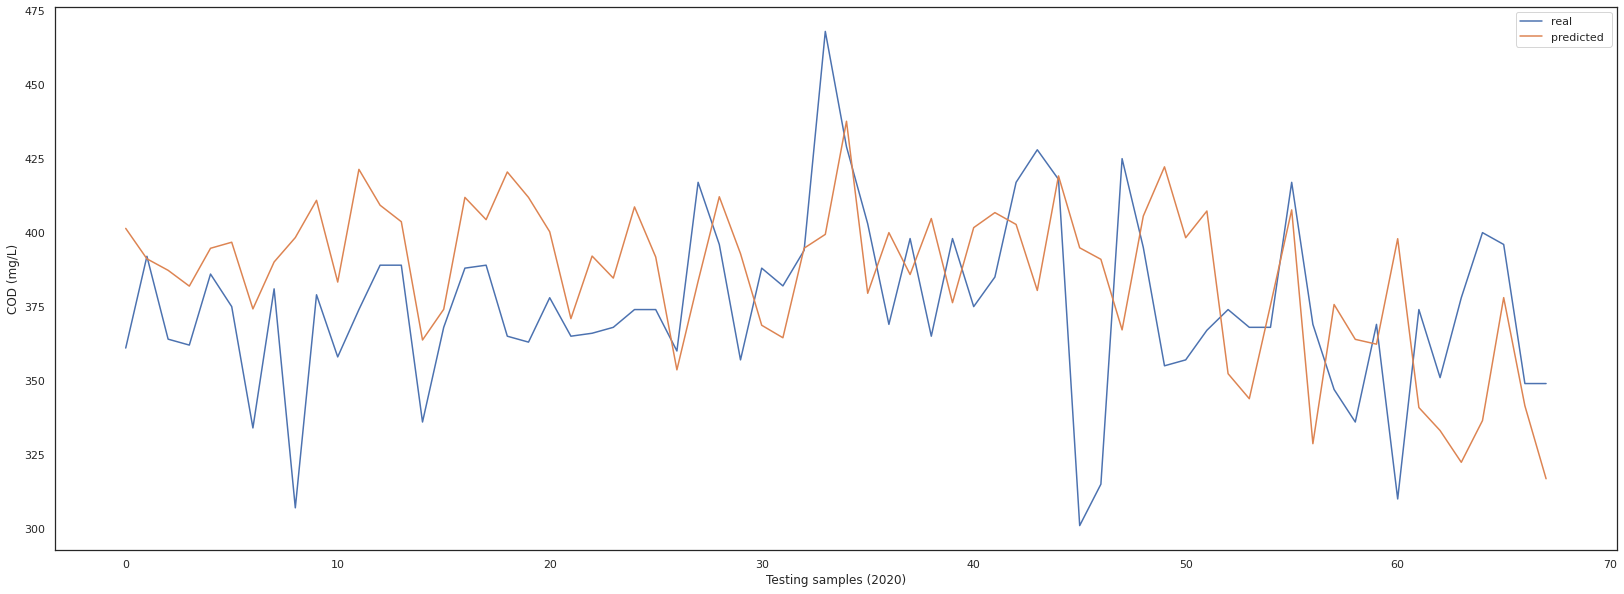

In [ ]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 6.978113   6.2112317  6.396598   5.797933   5.859136   6.271387
  6.405852   5.8669405  5.9454274  6.7139997  5.738797   5.760004
  5.8835998  5.8612576  6.2902436  6.1858354  5.7536592  6.243154
  6.3056827  5.73903    5.738233   5.8700433  5.73845    5.7392316
  5.743932   5.764012   5.7396603  5.739787   6.93127    6.5052867
  5.738408   6.0086193  6.2797775  7.4360175 11.016201   8.620972
  8.04146    7.283233   7.8778324  6.3556657  6.7257533  6.198022
  6.281413   6.93624    8.396734   7.9856815  5.8867564  6.271678
  6.907479   6.0038304  6.064431   5.740128   5.7391877  5.7719874
  5.7561135  5.7396507  7.564012   5.885106   5.74005    6.0798645
  5.7385616  7.824246   5.937697   6.4289227  5.7398696  5.858015
  6.22206    5.7562323], shape=(68,), dtype=float32)
MAPE:  6.3758190832885795
R2:  0.01845172591449107
RMSE:  28.930952405732732


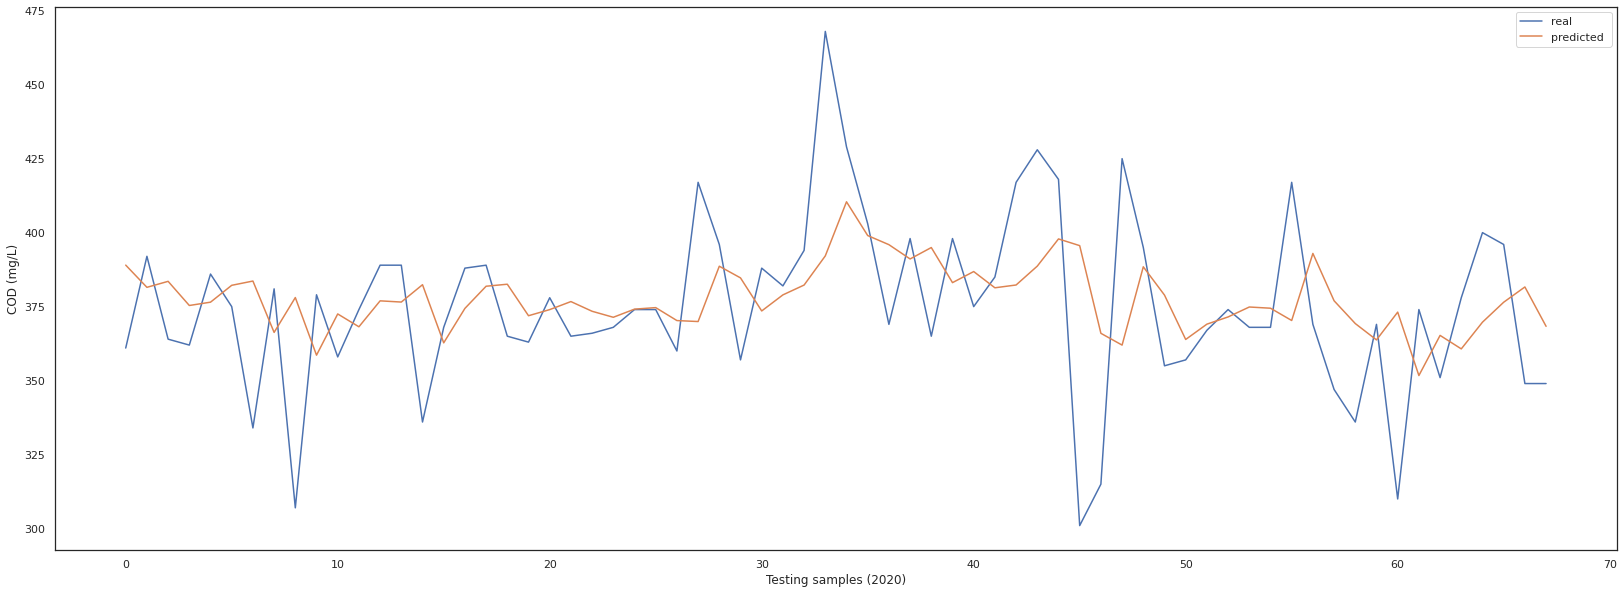

In [ ]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

      EQ_COD    model1    model2    model3
0   1.022051  1.506535  1.499882  1.568013
1   0.494727  1.479758  1.299474  1.403760
2   1.039628  1.271814  1.191780  1.325569
3   0.547459  1.153226  1.035465  1.286486
4   0.512304  1.211691  1.424424  1.283244
..       ...       ...       ...       ...
63  0.318952  0.673411 -0.165357  0.547106
64  0.793544  0.823848  0.098724  0.884948
65  1.180248  0.890819  1.086147  0.945981
66  1.109938  1.172841  0.152537  0.981748
67  0.283797  1.037783 -0.675379  0.701684

[68 rows x 4 columns]      0  1  2
0    1  0  0
1    0  1  0
2    1  0  0
3    0  1  0
4    1  0  0
..  .. .. ..
263  0  1  0
264  1  0  0
265  1  0  0
266  0  1  0
267  0  1  0

[268 rows x 3 columns]
3/3 [==============================] - 0s 4ms/step - loss: 1.1477 - accuracy: 0.3824
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(6.945682700177872, shape=(), dtype=float64)
MAPEsci:  2561.0381182502297
MAPE:  6.94568270017787
R2:  -0.3298048262826121
RMSE:  33.6744763776509

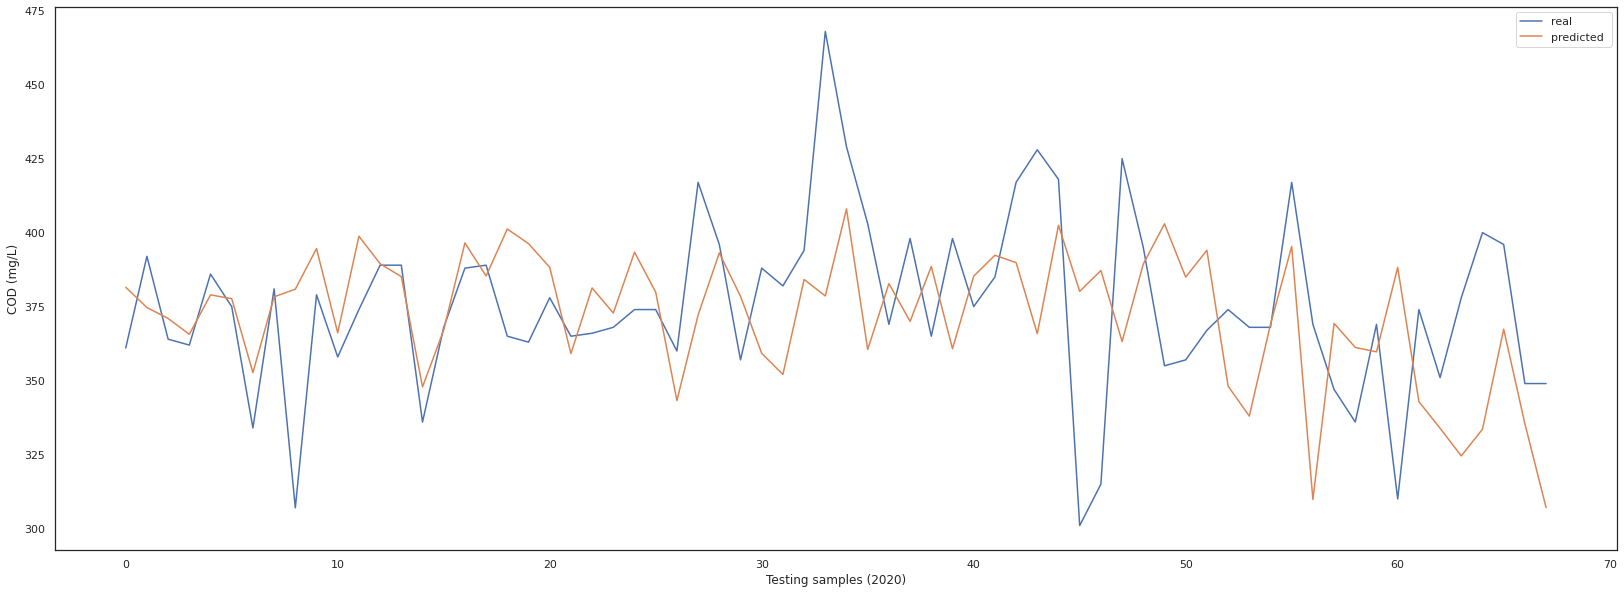

In [ ]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(3)

0

# D_COD_ON

In [ ]:
active_target = "D_COD_ON"
dataset = dataset1.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        343 non-null    object 
 1   Flow_to_EQ  343 non-null    object 
 2   Flow_efl    343 non-null    float64
 3   BT_C_MLSS   343 non-null    float64
 4   BT_C_MVLSS  343 non-null    float64
 5   BT_N_MLSS   343 non-null    float64
 6   BT_N_MVLSS  343 non-null    float64
 7   D_SS        343 non-null    float64
 8   EQ_N        343 non-null    float64
 9   BT_C_N      343 non-null    float64
 10  BT_N_N      343 non-null    float64
 11  D_N         343 non-null    float64
 12  OxT_PH_PM   343 non-null    float64
 13  EQ_PH       343 non-null    float64
 14  BT_N_PH     343 non-null    float64
 15  D_PH        343 non-null    float64
 16  BT_N_DO     343 non-null    float64
 17  BT_C_DO     343 non-null    float64
 18  Clari_DO    343 non-null    float64
 19  F/M         343 non-null    f

## Approach 1

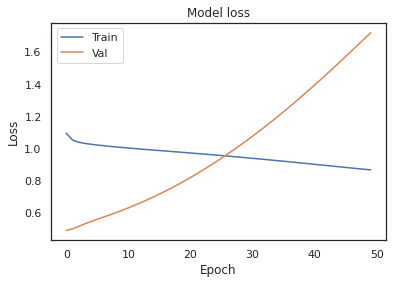

*** ANN estimation ***
MAPE:  12.51208203225828
R2:  0.4076196493225068
RMSE:  19.975920638006816


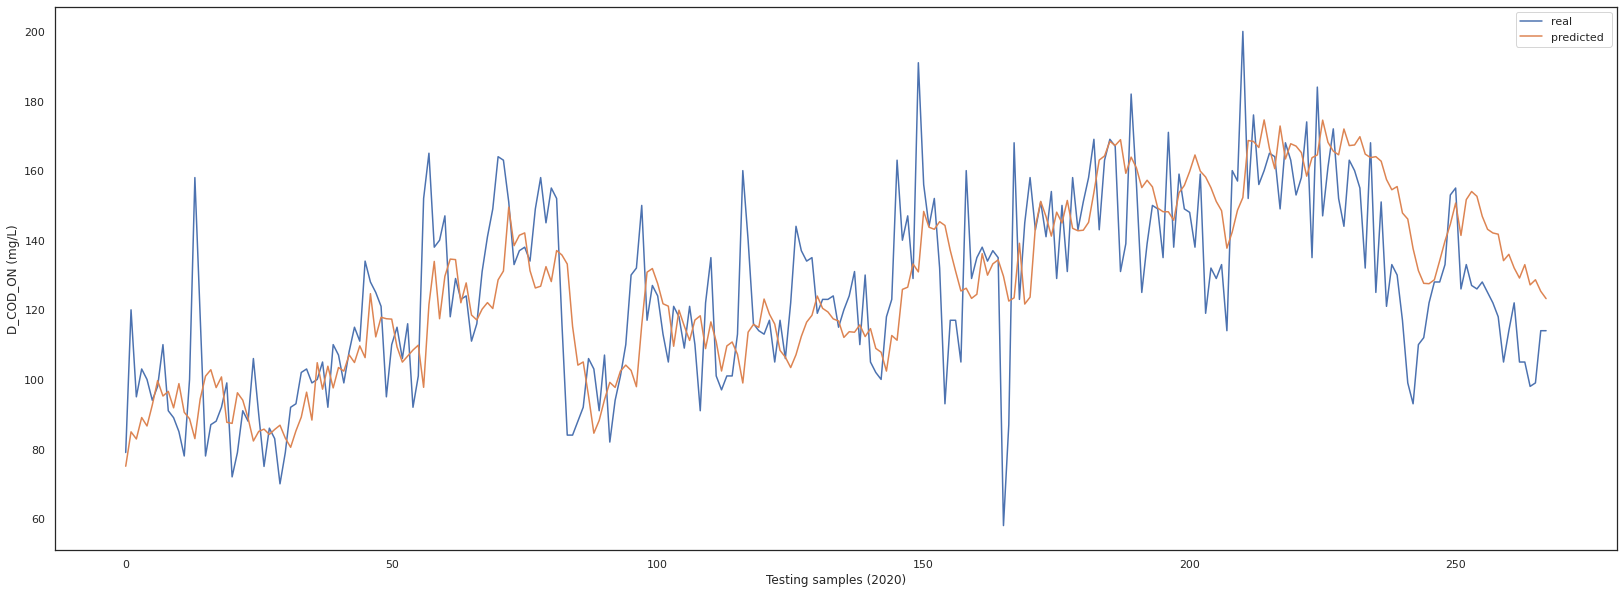

(268,)

In [ ]:
cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[2:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

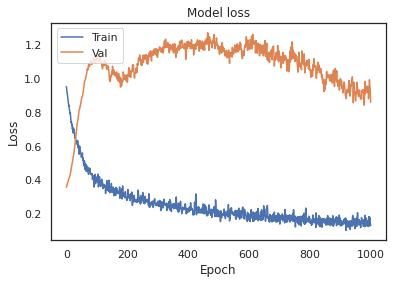

*** LSTM estimation ***
MAPE:  24.628280319802123
R2:  0.8456609137672955
RMSE:  10.196343177005916


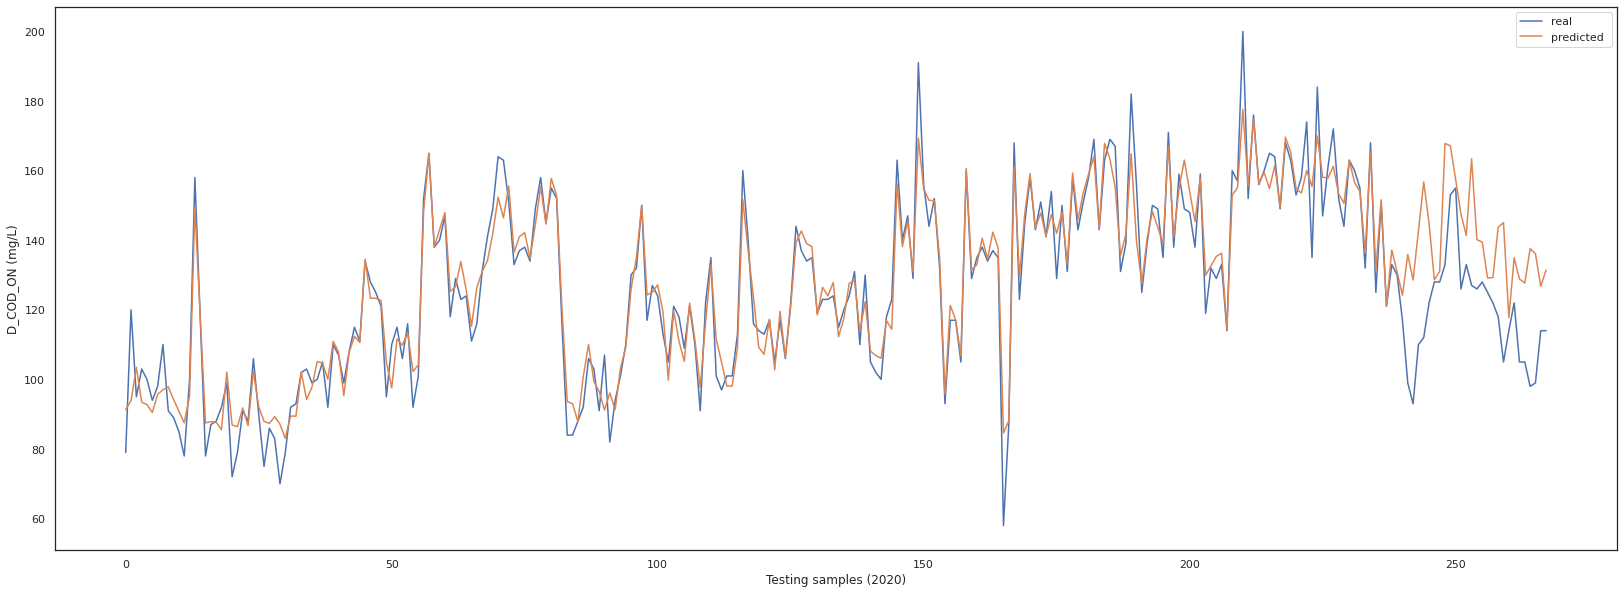

(268, 1)

In [ ]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=7)
app2.supervised
app2.training(max_epochs=1000)
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  10.707851305976293
R2:  0.5425029999885738
RMSE:  17.55499083167799


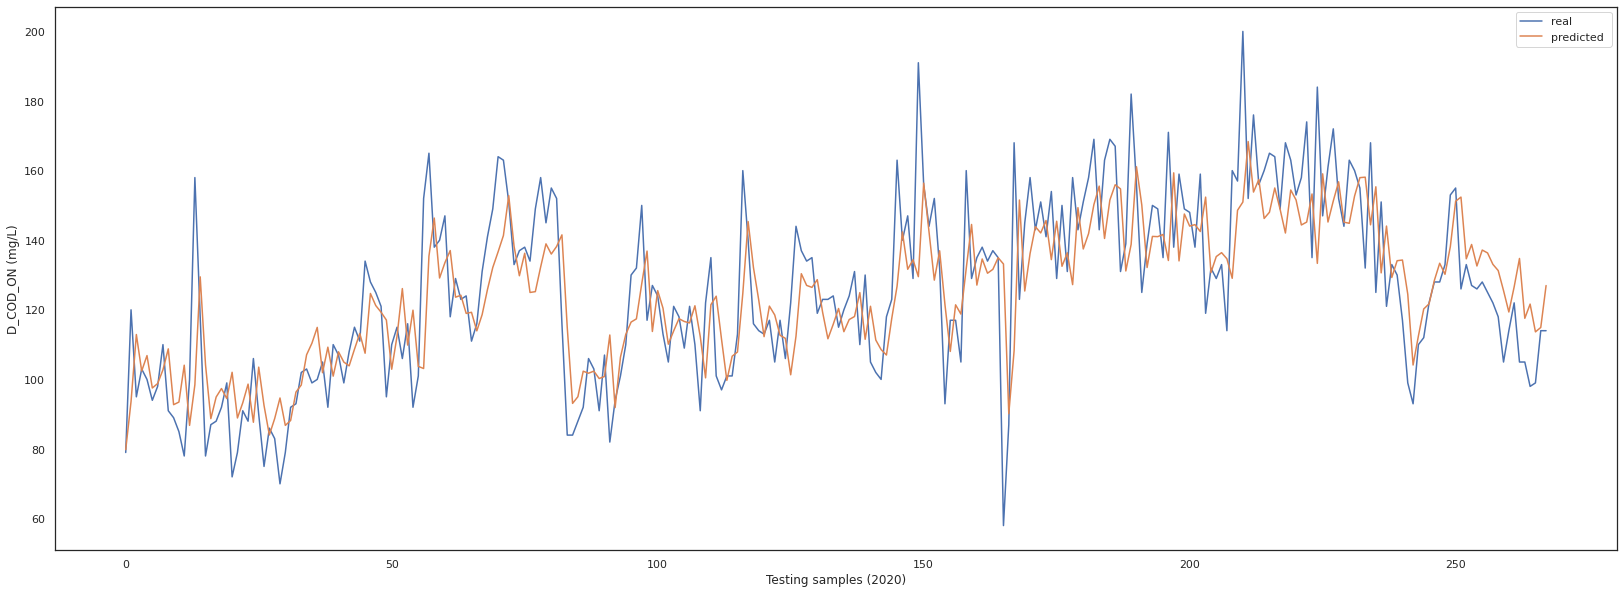

(268,)

In [ ]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

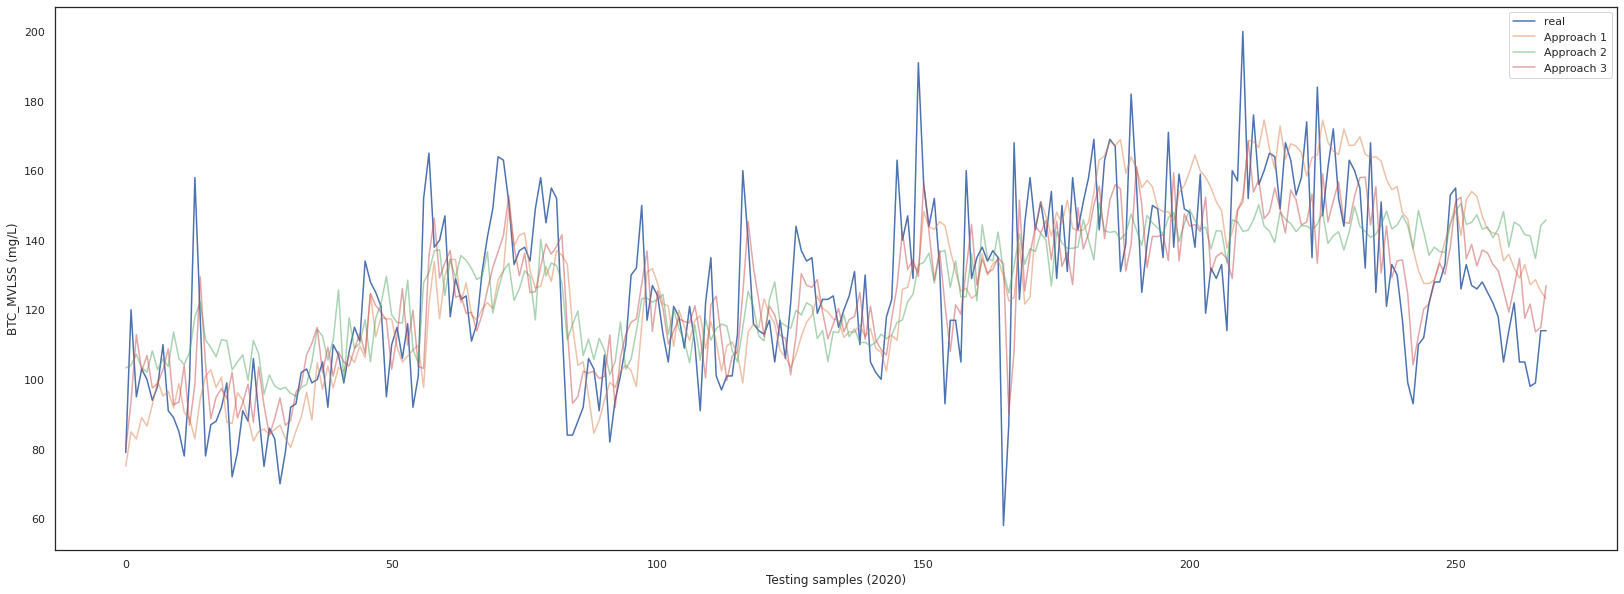

In [ ]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [ ]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      258.180196
1      282.676679
2      303.006777
3      294.771711
4      295.565695
          ...    
263    392.104838
264    390.056711
265    377.033855
266    384.469757
267    396.053887
Length: 268, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  10.947400078767114
R2:  0.532401374950479
RMSE:  17.747741497752568


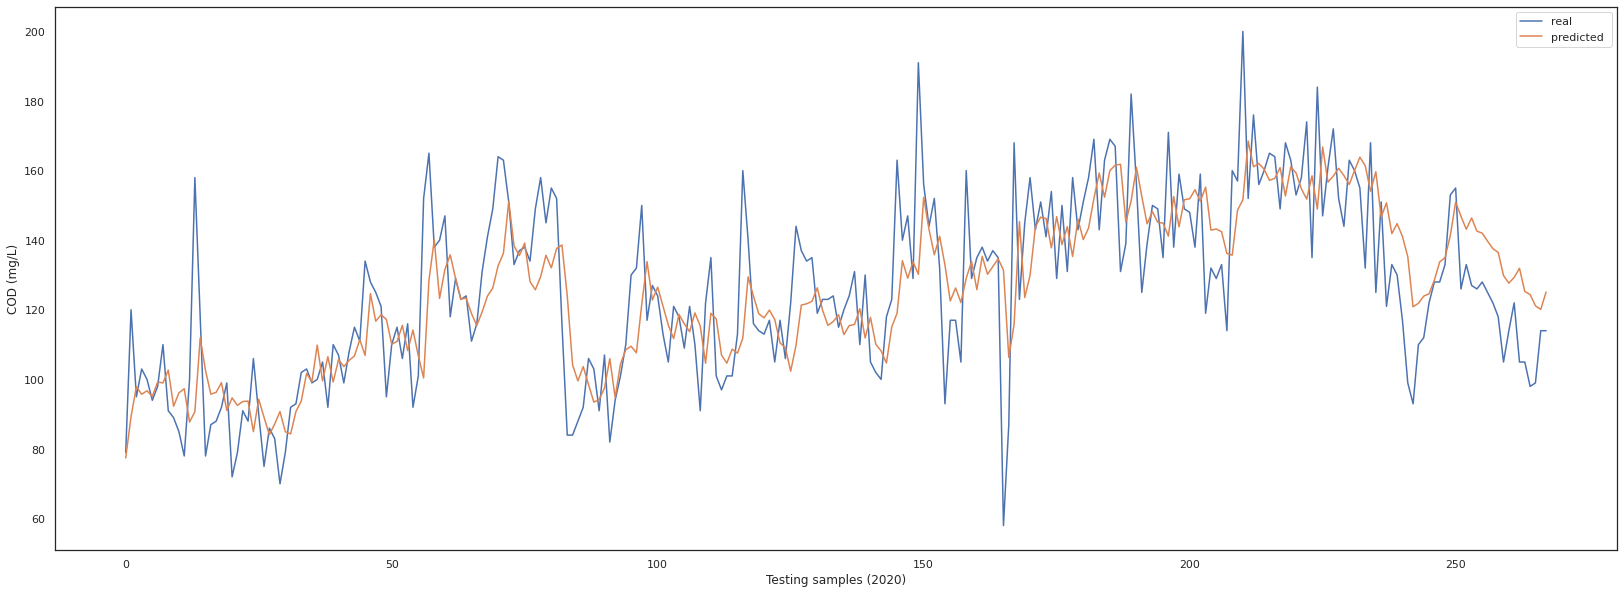

In [ ]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  11.345864586781056
R2:  0.5313637765189231
RMSE:  17.767421650094665


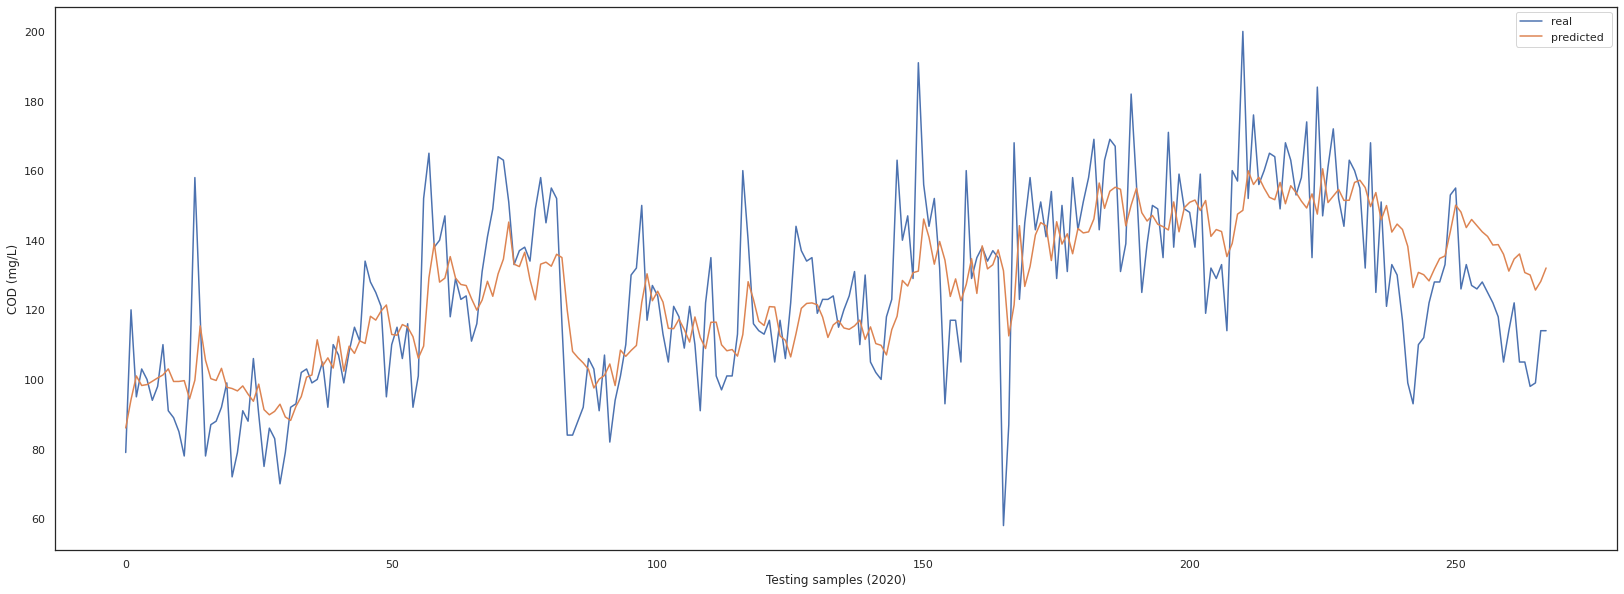

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

In [ ]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

NameError: ignored

In [ ]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


In [ ]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

In [ ]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

In [ ]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

In [ ]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(1)

### Ensemble 4

In [ ]:
class Ensemble4:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[['model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    # self.Y = self.df['target']
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    # self.y_mean = self.Y.mean()
    # self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
    # self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
  

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target']
    # print(self.Xt)

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean


    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [ ]:
# ensemble_model4 = Ensemble4(dataset.iloc[:-135], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
# ensemble_model4.training()

## Testing


*** ANN estimation ***
MAPE * Founded
MAPE:  59.567988589567
R2:  -0.7639141022797802
RMSE:  25.041783058389857


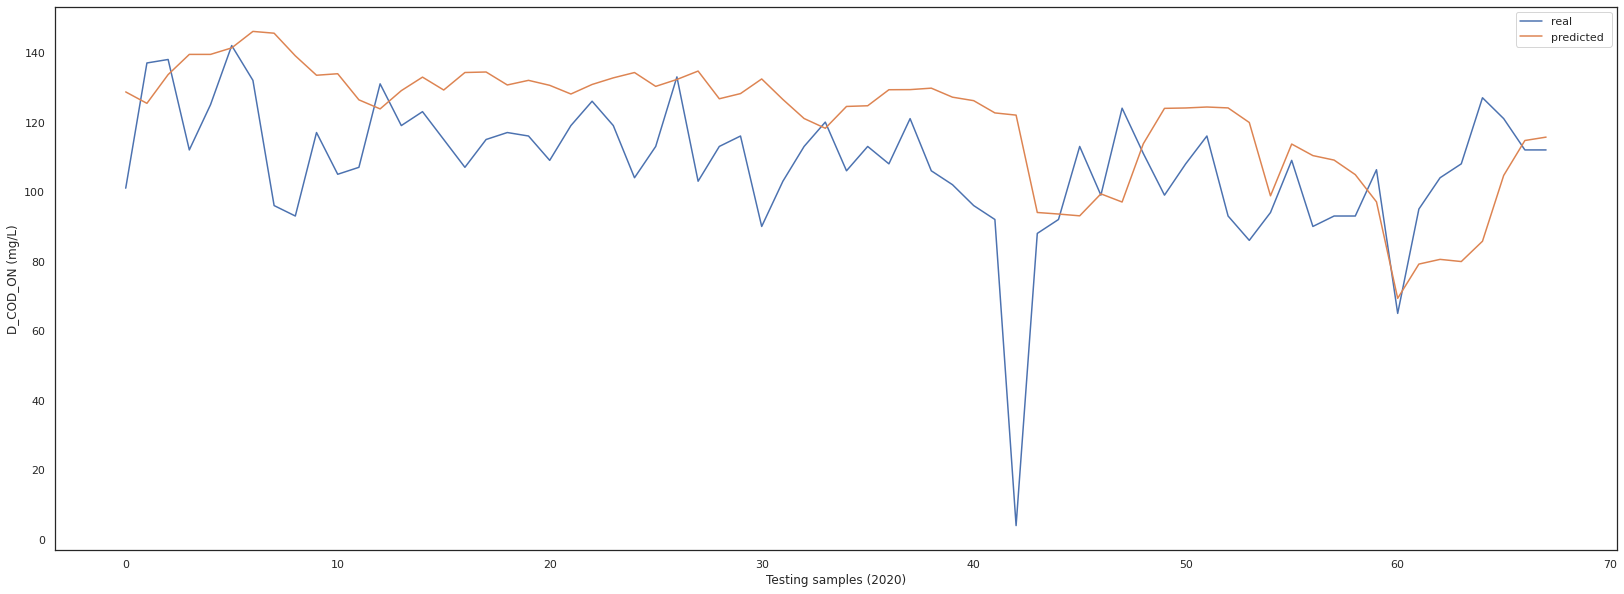

(68,)

In [ ]:
app1.testing(dataset.iloc[-(cut_off + 5):])
app1.full_prediction.shape

In [ ]:
app2.testing(dataset.iloc[-(cut_off + 7):])
app2.full_prediction.shape

In [ ]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

In [ ]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(3)